# Final Project : Named Entity Recognition (NER) & Parts of Speech (POS) tagging

### Team Members : 
- **Nikita Baldev Mandhan**


### Library Imports and Environment Setup

In [1]:
# This script includes a range of imports for data manipulation, visualization, machine learning, and natural language processing. 
# NumPy and pandas are used for data handling and preprocessing, while matplotlib and seaborn are for data visualization. 
# LabelEncoder and train_test_split from sklearn help in preparing the data for modeling, and accuracy_score is used to evaluate model performance.
# The keras preprocessing is used for preparing sequence data for deep learning models, and sklearn_crfsuite is for Conditional Random Fields
# Warnings are controlled for clean output, and TensorFlow's utilities are used for categorical encoding. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pickle as pkl
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
import sklearn_crfsuite
import warnings
from tensorflow.keras.utils import to_categorical
import string

from collections import Counter
import itertools

Using TensorFlow backend.


### Data Loading, Preprocessing, and Structuring for NER

In [2]:
#Read the dataset
df = pd.read_csv('ner_dataset.csv', encoding="latin1")

In [3]:
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [4]:
# Rename the sentence column for consistency.
df.rename(columns={'Sentence #': 'Sentence#'}, inplace=True)

In [5]:
df.head(40)

,Sentence#,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


##### Sentence Reconstruction and Data Structuring

In [6]:
# Function to reconstruct sentences from tokenized words and their corresponding POS and tags.
def reconstruct_sentences(data):
    # Initialize containers for sentences, POS tags, and NER tags.
    sentences = []
    sentence = []
    pos_tags = []
    ner_tags = []
    
    # Iterate over each row in the dataframe to rebuild sentence structure.
    for index, row in data.iterrows():
        # New sentence detection, append the previous one if it exists.
        if pd.notna(row['Sentence#']):
            if sentence:
                sentences.append((' '.join(sentence), ' '.join(pos_tags), ' '.join(ner_tags)))
                sentence = []
                pos_tags = []
                ner_tags = []
        word = row['Word']
        pos = row['POS']
        tag = row['Tag']
        # Append word, POS tag, and NER tag to the current sentence if they are valid.
        if pd.notna(word) and isinstance(word, str):
            sentence.append(word)
            pos_tags.append(pos)
            ner_tags.append(tag)
    
    # Append the last sentence if it hasn't been added already.
    if sentence:
        sentences.append((' '.join(sentence), ' '.join(pos_tags), ' '.join(ner_tags)))
    
    return sentences

In [7]:
sentences = reconstruct_sentences(df)
for sentence, pos, ner in sentences[:10]:
    print("Sentence:", sentence)
    print("POS tags:", pos)
    print("NER tags:", ner)
    print()

Sentence: Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
POS tags: NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP CC VB DT NN IN JJ NNS IN DT NN .
NER tags: O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O

Sentence: Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "
POS tags: NNS IN NNS VBN IN DT NN VBD DT NNS WP VBD NNS IN JJ NNS IN `` NNP NN CD NN `` CC `` VB DT NNS . ``
NER tags: O O O O O O O O O O O O O O O O O O B-per O O O O O O O O O O O

Sentence: They marched from the Houses of Parliament to a rally in Hyde Park .
POS tags: PRP VBD IN DT NNS IN NN TO DT NN IN NNP NNP .
NER tags: O O O O O O O O O O O B-geo I-geo O

Sentence: Police put the number of marchers at 10,000 while organizers claimed it was 1,00,000 .
POS tags: NNS VBD DT NN IN NNS IN CD IN NNS VBD

In [8]:
print(type(sentences[0]))
print(sentences[0])

<class 'tuple'>
('Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .', 'NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP CC VB DT NN IN JJ NNS IN DT NN .', 'O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O')


In [9]:
# Extract and prepare sentences and tags for further processing.
sample_sentences = [sentence_tuple[0] for sentence_tuple in sentences]
sample_POS_tags = [sentence_tuple[1] for sentence_tuple in sentences]
sample_tags = [sentence_tuple[2] for sentence_tuple in sentences]

##### Data Preprocessing and Cleanup

In [10]:
# Tokenize sentences and their corresponding tag sequences.
tokenized_sentences = [sentence.split() for sentence in sample_sentences]
tokenized_POS_tags = [POS_tag_sequence.split() for POS_tag_sequence in sample_POS_tags]
tokenized_tags = [tag_sequence.split() for tag_sequence in sample_tags]

In [11]:
# Count the total number of sentences and unique words.
total_sentences = len(tokenized_sentences)
print(f"Total number of sentences: {total_sentences}")

unique_words = set(word for sentence in tokenized_sentences for word in sentence)
print(f"Total number of unique words: {len(unique_words)}")

Total number of sentences: 47959
Total number of unique words: 35176


In [12]:
# Filter out sentences where the number of tokens does not match the number of tags.
filtered_sentences = []
filtered_POS_tags = []
filtered_tags = []

for tokens, POS_tags, tags in zip(tokenized_sentences, tokenized_POS_tags, tokenized_tags):
    if len(tokens) == len(POS_tags) == len(tags):
        filtered_sentences.append(tokens)
        filtered_POS_tags.append(POS_tags)
        filtered_tags.append(tags)
        
# Update tokenized sentences and tags with the filtered data.
tokenized_sentences = filtered_sentences
tokenized_POS_tags = filtered_POS_tags
tokenized_tags = filtered_tags

In [13]:
print(tokenized_sentences[:10])

[['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.'], ['Families', 'of', 'soldiers', 'killed', 'in', 'the', 'conflict', 'joined', 'the', 'protesters', 'who', 'carried', 'banners', 'with', 'such', 'slogans', 'as', '"', 'Bush', 'Number', 'One', 'Terrorist', '"', 'and', '"', 'Stop', 'the', 'Bombings', '.', '"'], ['They', 'marched', 'from', 'the', 'Houses', 'of', 'Parliament', 'to', 'a', 'rally', 'in', 'Hyde', 'Park', '.'], ['Police', 'put', 'the', 'number', 'of', 'marchers', 'at', '10,000', 'while', 'organizers', 'claimed', 'it', 'was', '1,00,000', '.'], ['The', 'protest', 'comes', 'on', 'the', 'eve', 'of', 'the', 'annual', 'conference', 'of', 'Britain', "'s", 'ruling', 'Labor', 'Party', 'in', 'the', 'southern', 'English', 'seaside', 'resort', 'of', 'Brighton', '.'], ['The', 'party', 'is', 'divided', 'over', 'Britain', "'s",

In [14]:
print(tokenized_POS_tags[:10])

[['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.'], ['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', 'VBD', 'DT', 'NNS', 'WP', 'VBD', 'NNS', 'IN', 'JJ', 'NNS', 'IN', '``', 'NNP', 'NN', 'CD', 'NN', '``', 'CC', '``', 'VB', 'DT', 'NNS', '.', '``'], ['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', 'TO', 'DT', 'NN', 'IN', 'NNP', 'NNP', '.'], ['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', 'CD', 'IN', 'NNS', 'VBD', 'PRP', 'VBD', 'CD', '.'], ['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', 'NNP', 'POS', 'VBG', 'NNP', 'NNP', 'IN', 'DT', 'JJ', 'JJ', 'NN', 'NN', 'IN', 'NNP', '.'], ['DT', 'NN', 'VBZ', 'VBN', 'IN', 'NNP', 'POS', 'NN', 'IN', 'DT', 'NNP', 'NN', 'CC', 'DT', 'JJ', 'NN', 'IN', 'CD', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.'], ['DT', 'NNP', 'NN', 'VBD', 'RB', 'IN', 'JJ', 'NNS', 'NN', 'IN', 'JJ', 'NNS', ',', 'VBG', 'NNP', ',', 'NNP', ',', 'CC', 'NNP', '.'], ['DT', 'NNP', 'NNP', 'NNP',

In [15]:
print(tokenized_tags[:10])

[['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'B-org', 'I-org', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'B-geo', 'O'], ['O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O'], ['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-geo', 'O', 'O', 'B-geo', 'O'], ['O', 'B-org', 'I-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O',

In [16]:
# Count the total number of sentences and unique words after removing mismatches
total_sentences = len(tokenized_sentences)
print(f"Total number of sentences: {total_sentences}")

unique_words = set(word for sentence in tokenized_sentences for word in sentence)
print(f"Total number of unique words: {len(unique_words)}")

Total number of sentences: 47955
Total number of unique words: 35169


**Note:** In the initial dataset for Named Entity Recognition (NER), we had 47,959 sentences with 35,176 unique words. However, during data validation, we identified sentences where the number of tokens didn't match the corresponding tags. Post-cleaning, the dataset contained 47,955 sentences and 35,169 unique words, indicating that 4 sentences were removed due to mismatches. Ensuring data alignment is crucial for effective model training and to avoid potential errors during model evaluations.

### Exploratory Data Analysis (EDA): Sentence Length Distribution

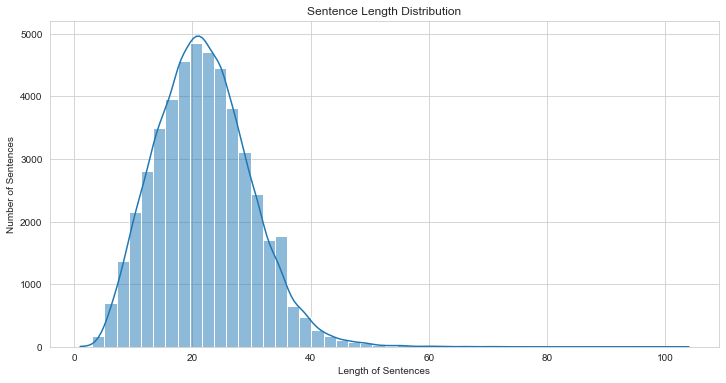

In [17]:
# Set style
sns.set_style("whitegrid")

# Calculate the length of each sentence
sentence_lengths = [len(sentence) for sentence in tokenized_sentences]

# Create a histogram to visualize the distribution of sentence lengths
plt.figure(figsize=(12, 6))
sns.histplot(sentence_lengths, bins=50, kde=True)
plt.title('Sentence Length Distribution')
plt.xlabel('Length of Sentences')
plt.ylabel('Number of Sentences')
plt.show()

**Note:** The histogram illustrates the distribution of sentence lengths in the dataset. Most sentences range from 10-30 words, forming a near-normal distribution with a slight skew to the right. While the bulk of the data clusters around this average length, there are a few longer sentences, though they become increasingly rare past 60 words. This information can guide decisions on sequence lengths when modeling.

### EDA: Tag Frequency Distribution

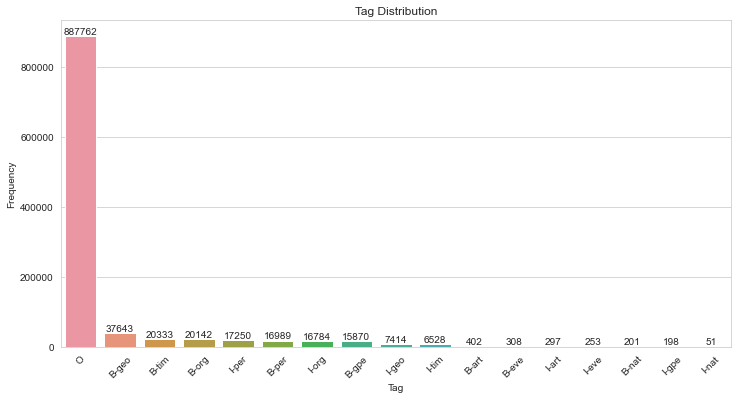

In [18]:
# Flatten the list of all tags
all_tags = [tag for tags_list in tokenized_tags for tag in tags_list]

# Create a barplot to visualize the frequency of each tag
plt.figure(figsize=(12, 6))
tag_counts = pd.Series(all_tags).value_counts()
sns.barplot(x=tag_counts.index, y=tag_counts.values)

# Displaying the counts on top of each bar
for index, value in enumerate(tag_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.title('Tag Distribution')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

**Note:** The chart displays the frequency of tags in the dataset. The "O" tag dominates, indicating most words aren't specific entities. Tags like 'B-geo', 'B-tim', and 'B-org' are also common, representing locations, times, and organizations. However, 'I-art', 'B-eve', and 'I-nat' are rare, denoting artworks, events, and natural phenomena.

### EDA: Tag Distribution Excluding 'O' Tag

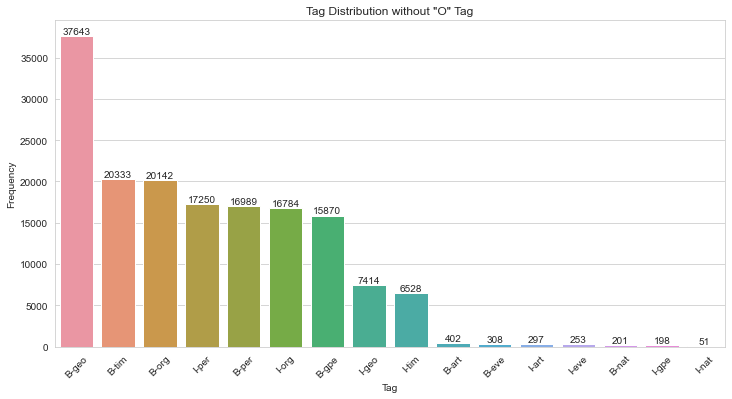

In [19]:
all_tags = [tag for tags_list in tokenized_tags for tag in tags_list]
plt.figure(figsize=(12, 6))

# Filter out the 'O' tag
tag_counts = pd.Series(all_tags).value_counts().drop('O')
sns.barplot(x=tag_counts.index, y=tag_counts.values)

# Displaying the counts on top of each bar
for index, value in enumerate(tag_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.title('Tag Distribution without "O" Tag')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

**Note:** The chart displays tag frequencies, excluding the "O" tag. 'B-geo' stands out as the most frequent, indicating a high mention of geographical locations. Tags 'B-tim', 'B-org', and 'I-per' are also relatively common, denoting time, organizations, and individual names. However, the tags towards the right, like 'I-eve', 'B-nat', and 'I-nat', are less frequent, highlighting fewer mentions of events and natural phenomena.

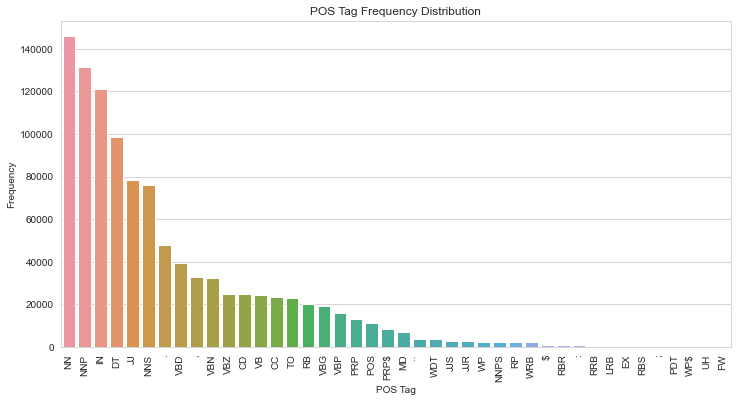

In [20]:
# Count the frequency of each POS tag
pos_tag_counts = pd.Series([tag for tags_list in tokenized_POS_tags for tag in tags_list]).value_counts()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=pos_tag_counts.index, y=pos_tag_counts.values)
plt.title('POS Tag Frequency Distribution')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

### EDA: Most Common Words in the Dataset

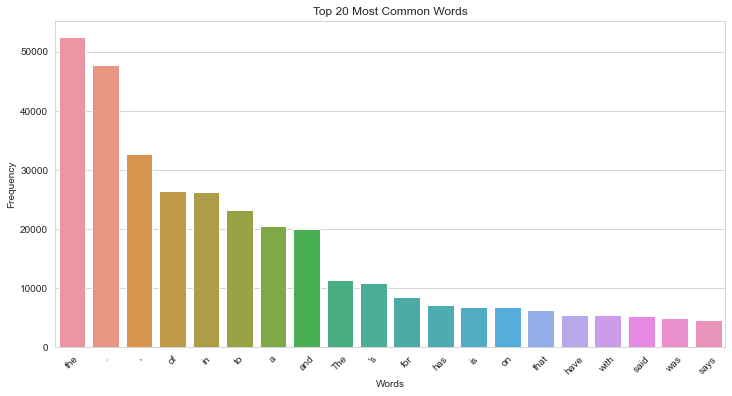

In [21]:
all_words = [word for sentence in tokenized_sentences for word in sentence]
word_freq = pd.Series(all_words).value_counts().head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=word_freq.index, y=word_freq.values)
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

**Note:** The chart illustrates the top 20 most frequent words. Many of these words are common English stop words such as 'the', ',', 'of', 'in', and 'to', indicating their prevalence in textual data. While these words are frequent, they often don't add significant meaning on their own. The presence of words like 'and', 'that', and 'is' further underlines the importance of considering context in textual analysis. Less common but still frequent words like 'said' and 'with' give a glimpse into the possible narrative or descriptive nature of the dataset.

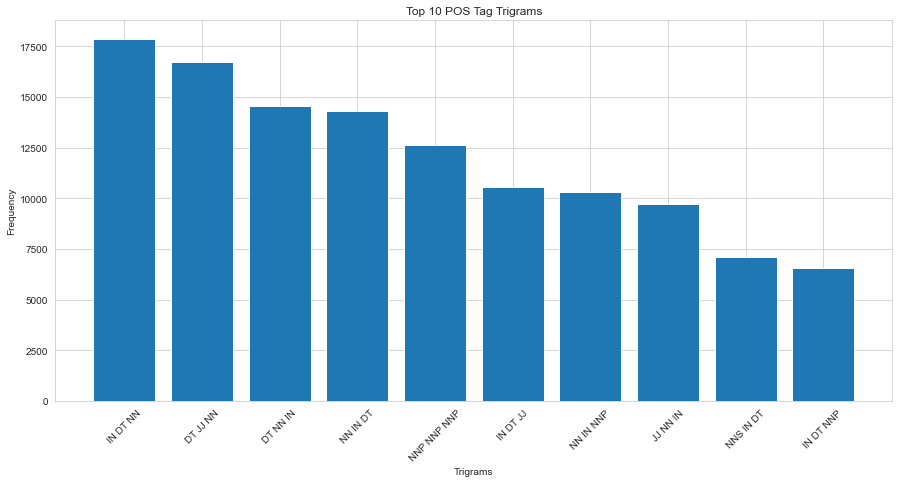

In [22]:
from nltk.util import ngrams
from collections import Counter

# Function to get most common n-grams
def get_most_common_ngrams(tokenized_tags, n, top_k=10):
    ngrams_list = [ngram for tags in tokenized_tags for ngram in ngrams(tags, n)]
    return Counter(ngrams_list).most_common(top_k)

# Get the top 10 trigrams
top_trigrams = get_most_common_ngrams(tokenized_POS_tags, 3, 10)
# Assuming 'top_trigrams' is obtained from the previous code
top_trigrams, frequencies = zip(*top_trigrams)

# Convert n-grams to a readable format for plotting
trigram_labels = [' '.join(trigram) for trigram in top_trigrams]

# Create a bar plot
plt.figure(figsize=(15, 7))
plt.bar(trigram_labels, frequencies)
plt.title('Top 10 POS Tag Trigrams')
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### EDA: Word Length Distribution

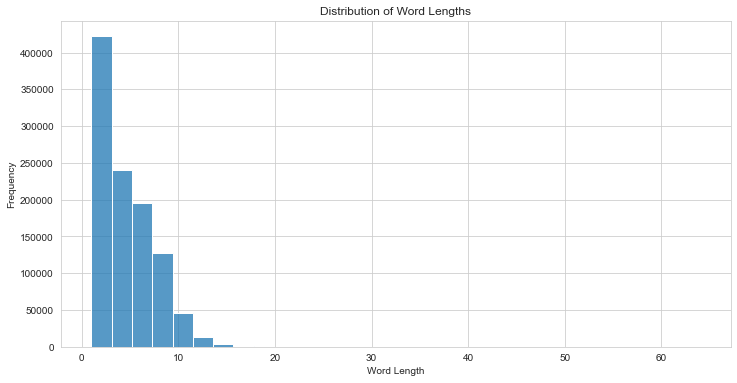

In [23]:
word_lengths = [len(word) for word in all_words]
plt.figure(figsize=(12, 6))
sns.histplot(word_lengths, bins=30)
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()

**Note:** The majority of words are concentrated between 1 to 10 characters, with the peak frequency observed for words of around 3-4 characters. The frequency gradually decreases as word length increases, indicating that longer words are less common. Very few words exceed a length of 20 characters. This distribution suggests that the dataset mainly contains common, shorter words, with occasional occurrences of longer, possibly technical or compound terms.

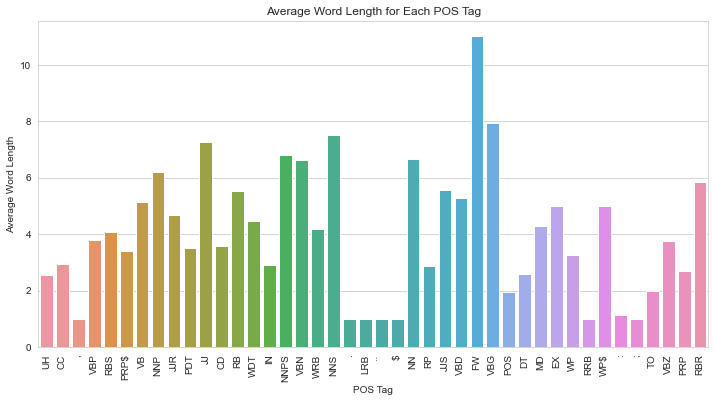

In [24]:
# Create a dictionary to store average word length for each POS tag
pos_word_lengths = {pos_tag: [] for pos_tag in set(tag for tags in tokenized_POS_tags for tag in tags)}

# Populate the dictionary
for sentence, pos_tags in zip(tokenized_sentences, tokenized_POS_tags):
    for word, tag in zip(sentence, pos_tags):
        pos_word_lengths[tag].append(len(word))

# Calculate average word length for each POS tag
avg_word_length_per_pos = {tag: np.mean(lengths) for tag, lengths in pos_word_lengths.items()}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(avg_word_length_per_pos.keys()), y=list(avg_word_length_per_pos.values()))
plt.title('Average Word Length for Each POS Tag')
plt.xlabel('POS Tag')
plt.ylabel('Average Word Length')
plt.xticks(rotation=90)
plt.show()

### EDA: NER Tag Co-occurrence 

**Note:** The heatmap displays co-occurrence patterns of NER tags. Notably, the O tag frequently co-occurs with B-per and I-per, indicating many generic tokens appear alongside person-related tokens. Other combinations, like B-geo and I-geo, also co-occur often, hinting at multi-token geographical entities.

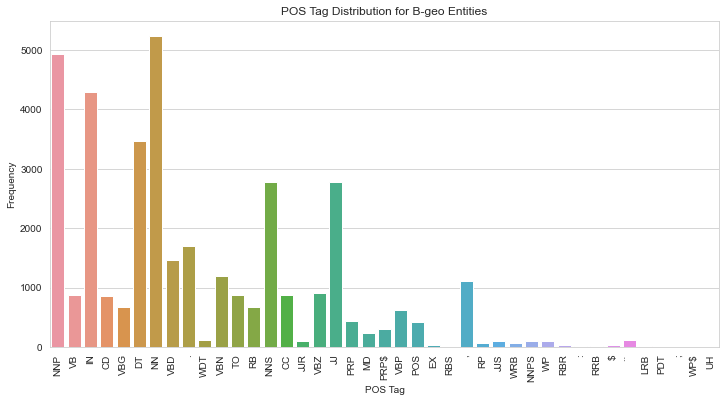

In [25]:
# Assuming you have a list of entity types corresponding to each word
entity_types = [tag_sequence.split() for tag_sequence in sample_tags]  # Adjust as per your data structure

# Function to get POS distribution for a specific entity type
def pos_distribution_for_entity(entity_type, pos_tags, entities):
    pos_tags_for_entity = [pos for pos, entity in zip(pos_tags, entities) if entity == entity_type]
    return Counter(pos_tags_for_entity)

# Example: POS distribution for 'B-geo'
b_geo_pos_distribution = pos_distribution_for_entity('B-geo', [tag for tags_list in tokenized_POS_tags for tag in tags_list], [entity for entities in entity_types for entity in entities])

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=list(b_geo_pos_distribution.keys()), y=list(b_geo_pos_distribution.values()))
plt.title('POS Tag Distribution for B-geo Entities')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


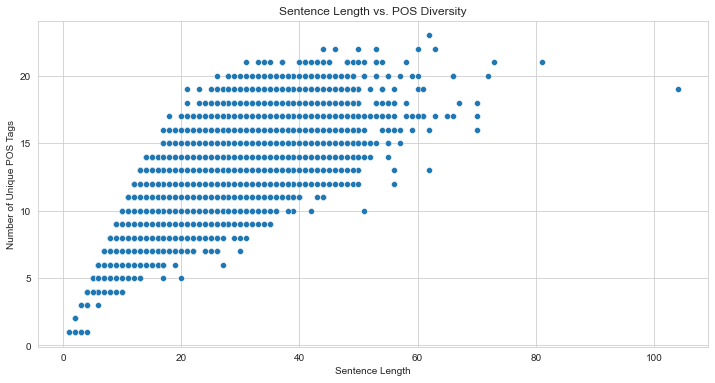

In [26]:
# Calculate the number of unique POS tags in each sentence
pos_diversity = [len(set(tags)) for tags in tokenized_POS_tags]

# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x=sentence_lengths, y=pos_diversity)
plt.title('Sentence Length vs. POS Diversity')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Unique POS Tags')
plt.show()


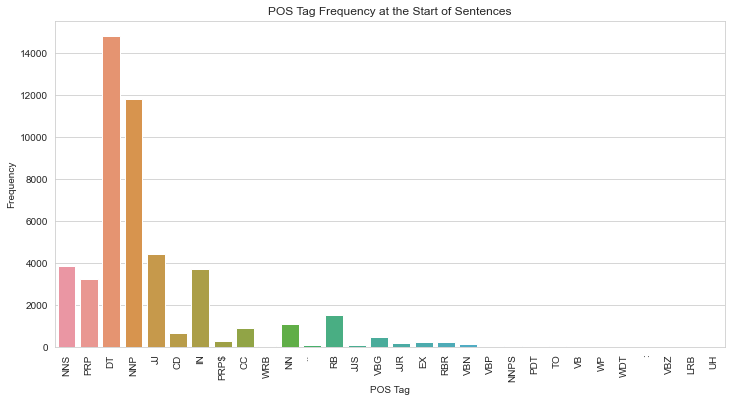

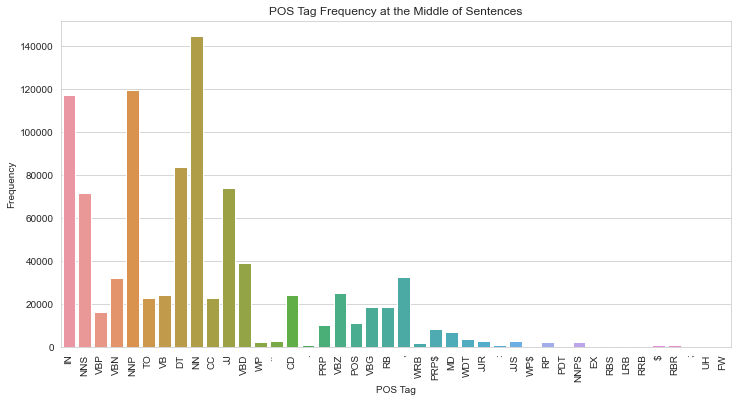

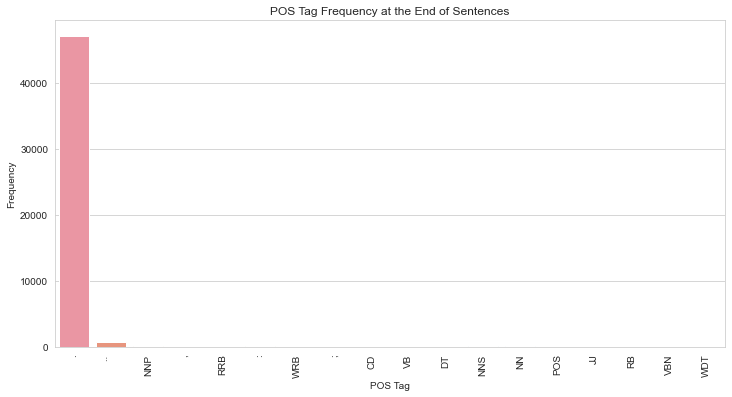

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to count POS tags at different sentence positions
def count_pos_at_positions(pos_tags, position):
    if position == 'start':
        return Counter([tags[0] for tags in pos_tags if tags])
    elif position == 'end':
        return Counter([tags[-1] for tags in pos_tags if tags])
    else:  # middle
        return Counter([tag for tags in pos_tags for tag in tags[1:-1]])

# Count for start, middle, and end of sentences
start_pos_counts = count_pos_at_positions(tokenized_POS_tags, 'start')
middle_pos_counts = count_pos_at_positions(tokenized_POS_tags, 'middle')
end_pos_counts = count_pos_at_positions(tokenized_POS_tags, 'end')

# Plotting the POS tag counts at different sentence positions
def plot_pos_counts(counts, position):
    tags, frequencies = zip(*counts.items())
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(tags), y=list(frequencies))
    plt.title(f'POS Tag Frequency at the {position} of Sentences')
    plt.xlabel('POS Tag')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

# Plot for the start of sentences
plot_pos_counts(start_pos_counts, "Start")

# Plot for the middle of sentences
plot_pos_counts(middle_pos_counts, "Middle")

# Plot for the end of sentences
plot_pos_counts(end_pos_counts, "End")

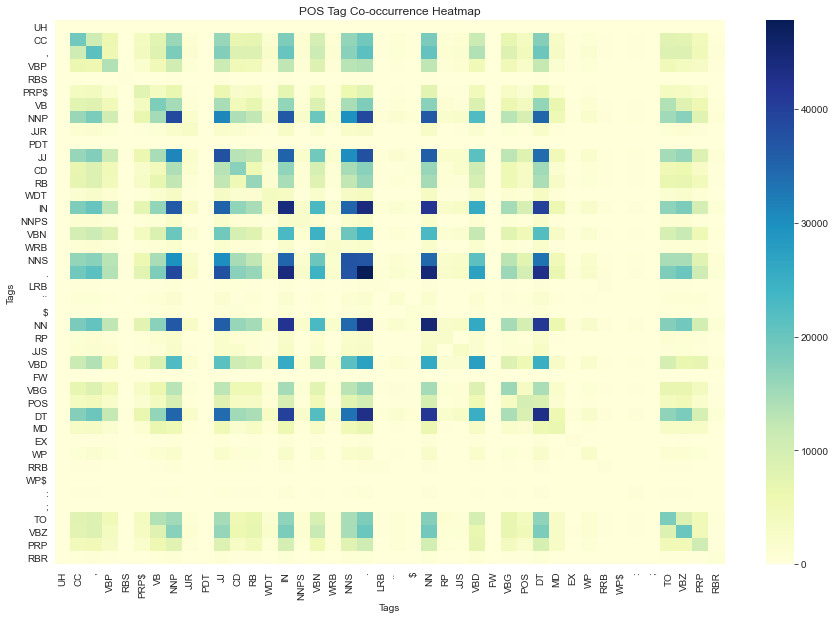

In [28]:
# Similar to NER tag co-occurrence function
def pos_cooccurrence_matrix(tokenized_tags):
    all_tags = list(set(tag for tags in tokenized_tags for tag in tags))
    comat = np.zeros((len(all_tags), len(all_tags)))

    for tags in tokenized_tags:
        for (tag1, tag2) in itertools.combinations_with_replacement(set(tags), 2):
            i, j = all_tags.index(tag1), all_tags.index(tag2)
            comat[i][j] += 1
            if i != j:
                comat[j][i] += 1

    return comat, all_tags

# Create the co-occurrence matrix
co_matrix, co_tags = pos_cooccurrence_matrix(tokenized_POS_tags)

# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(co_matrix, annot=False, xticklabels=co_tags, yticklabels=co_tags, cmap="YlGnBu")
plt.title('POS Tag Co-occurrence Heatmap')
plt.xlabel('Tags')
plt.ylabel('Tags')
plt.show()


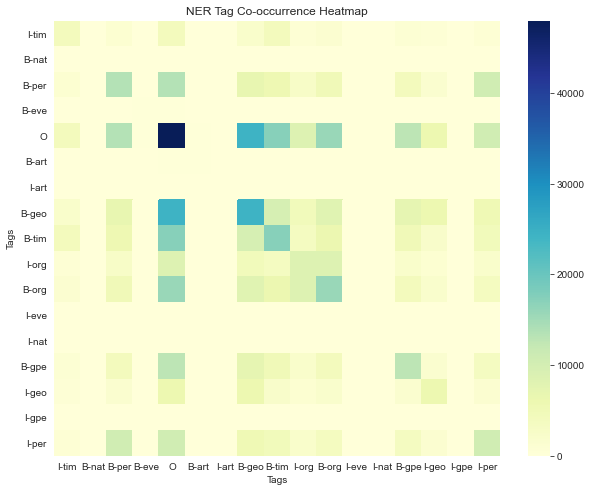

In [29]:
# Count co-occurrences of NER tags
def cooccurrence_matrix(tag_sequences):
    all_tags = list(set(tag for tags in tag_sequences for tag in tags))
    comat = np.zeros((len(all_tags), len(all_tags)))

    for tags in tag_sequences:
        for (tag1, tag2) in itertools.combinations_with_replacement(set(tags), 2):
            i, j = all_tags.index(tag1), all_tags.index(tag2)
            comat[i][j] += 1
            if i != j:
                comat[j][i] += 1

    return comat, all_tags

# Create the co-occurrence matrix
co_matrix, co_tags = cooccurrence_matrix(tokenized_tags)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=False, xticklabels=co_tags, yticklabels=co_tags, cmap="YlGnBu")
plt.title('NER Tag Co-occurrence Heatmap')
plt.xlabel('Tags')
plt.ylabel('Tags')
plt.show()

## Feature Extraction and Data Preparation for Sequence Tagging Models


### Splitting Data for CRF NER tagging

In [30]:
#extract features from a given word in a sentence
def word2features_NER(sent, i):
    word = sent[i]

    features = {
        'bias': 1.0,
        'word': word,  # Original word
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    
    # Add features for the previous word (if not at the beginning)
    if i > 0:
        word1 = sent[i-1]
        features.update({
            '-1:word': word1,  # Original previous word
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True
    # Add features for the next word (if not at the end)
    if i < len(sent)-1:
        word1 = sent[i+1]
        features.update({
            '+1:word': word1,  # Original next word
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features

#transform a sentence into a list of features
def sent2features_NER(sent):
    return [word2features_NER(sent, i) for i in range(len(sent))]

In [31]:
X_NER = [sent2features_NER(s) for s in tokenized_sentences]
y_NER = tokenized_tags

In [32]:
# Split the dataset into training and test sets for the CRF model
X_NER_t, X_NER_test, y_NER_t, y_NER_test = train_test_split(X_NER, y_NER, test_size=0.2, random_state=42)

In [33]:
# Identify any mismatches between tokens and tags
mismatched = [(tokens, tags) for tokens, tags in zip(tokenized_sentences, tokenized_tags) if len(tokens) != len(tags)]
for tokens, tags in mismatched:
    print("Tokens:", tokens)
    print("Tags:", tags)
    print()

### Splitting Data for CRF POS tagging

In [34]:
def word2features_POS(sent, i):
    word = sent[i]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),  # Lowercase word
        'word[-3:]': word[-3:],  # Last 3 characters
        'word[-2:]': word[-2:],  # Last 2 characters
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    
    if i > 0:
        word1 = sent[i-1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features

def sent2features_POS(sent):
    return [word2features_POS(sent, i) for i in range(len(sent))]

In [35]:
X_POS = [sent2features_POS(s) for s in tokenized_sentences]
y_POS = tokenized_POS_tags

In [36]:
X_POS_t, X_POS_test, y_POS_t, y_POS_test = train_test_split(X_POS, y_POS, test_size=0.2, random_state=42)

In [37]:
mismatched_POS = [(tokens, pos_tags) for tokens, pos_tags in zip(tokenized_sentences, tokenized_POS_tags) if len(tokens) != len(pos_tags)]
for tokens, pos_tags in mismatched_POS:
    print("Tokens:", tokens)
    print("POS Tags:", pos_tags)
    print()

### Splitting Data for BiLSTM, BiLSTM+CRF and CNN

In [38]:
# Vocabulary and tags setup for neural network models
words = ["<PAD>"] + list(set(word for sentence in tokenized_sentences for word in sentence))
tags_set = list(set(tag for tag_sequence in tokenized_tags for tag in tag_sequence))
# Setup for POS tags
pos_tags_set = list(set(pos_tag for pos_tag_sequence in tokenized_POS_tags for pos_tag in pos_tag_sequence))


# Mappings from word/tag to a unique index
word2idx = {word: i for i, word in enumerate(words)}

# Mappings for NER tags
tag2idx = {tag: i for i, tag in enumerate(tags_set)}
idx2tag = {i: tag for tag, i in tag2idx.items()}

# Mappings for POS tags
pos_tag2idx = {pos_tag: i for i, pos_tag in enumerate(pos_tags_set)}
pos_tag2idx['<PAD>'] = len(pos_tag2idx)  # Add a padding token
idx2pos_tag = {i: pos_tag for pos_tag, i in pos_tag2idx.items()}

In [39]:
# Print first 10 items from word2idx
print(list(word2idx.items())[:10])

# Print items from tag2idx
print(list(tag2idx.items()))

# Print items from idx2tag
print(list(idx2tag.items()))

# Print items from pos_tag2idx
print(list(pos_tag2idx.items()))

# Print items from idx2pos_tag
print(list(idx2pos_tag.items()))

[('<PAD>', 0), ('72.64', 1), ('mislead', 2), ('Lula', 3), ('alien', 4), ('DD', 5), ('Blackburn', 6), ('co-conspirator', 7), ('eradication', 8), ('historic', 9)]
[('I-tim', 0), ('B-nat', 1), ('B-per', 2), ('B-eve', 3), ('O', 4), ('B-art', 5), ('I-art', 6), ('B-geo', 7), ('B-tim', 8), ('I-org', 9), ('B-org', 10), ('I-eve', 11), ('I-nat', 12), ('B-gpe', 13), ('I-geo', 14), ('I-gpe', 15), ('I-per', 16)]
[(0, 'I-tim'), (1, 'B-nat'), (2, 'B-per'), (3, 'B-eve'), (4, 'O'), (5, 'B-art'), (6, 'I-art'), (7, 'B-geo'), (8, 'B-tim'), (9, 'I-org'), (10, 'B-org'), (11, 'I-eve'), (12, 'I-nat'), (13, 'B-gpe'), (14, 'I-geo'), (15, 'I-gpe'), (16, 'I-per')]
[('UH', 0), ('CC', 1), (',', 2), ('VBP', 3), ('RBS', 4), ('PRP$', 5), ('VB', 6), ('NNP', 7), ('JJR', 8), ('PDT', 9), ('JJ', 10), ('CD', 11), ('RB', 12), ('WDT', 13), ('IN', 14), ('NNPS', 15), ('VBN', 16), ('WRB', 17), ('NNS', 18), ('.', 19), ('LRB', 20), ('``', 21), ('$', 22), ('NN', 23), ('RP', 24), ('JJS', 25), ('VBD', 26), ('FW', 27), ('VBG', 28), ('

In [40]:
# Padding the sequences to ensure consistent input size
MAX_LEN = max([len(sentence) for sentence in tokenized_sentences])
X_data = [[word2idx[word] for word in sentence] for sentence in tokenized_sentences]
X_data = pad_sequences(X_data, maxlen=MAX_LEN, padding='post', value=word2idx["<PAD>"])

# Padding the NER tags to ensure consistent format
Y_data = [[tag2idx[tag] for tag in tags] for tags in tokenized_tags]
Y_data = pad_sequences(Y_data, maxlen=MAX_LEN, padding='post', value=tag2idx["O"])

# Padding the POS tags
Y_data_POS = [[pos_tag2idx[pos_tag] for pos_tag in pos_tags] for pos_tags in tokenized_POS_tags]
Y_data_POS = pad_sequences(Y_data_POS, maxlen=MAX_LEN, padding='post', value=pos_tag2idx['<PAD>'])

In [41]:
X_data[0]

array([25392,  2426, 24119,  8386,  5563, 21916, 12370, 27035, 30570,
       29656, 28250, 32337, 20796,  8633, 14642, 29656, 30041,  2426,
        7251, 20813, 19561,  5766, 17258, 17884,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [42]:
print([words[i] for i in X_data[0]])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [43]:
Y_data[0]

array([ 4,  4,  4,  4,  4,  4,  7,  4,  4,  4,  4,  4,  7,  4,  4,  4,  4,
        4, 13,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4])

In [44]:
print([idx2tag[i] for i in Y_data[0]])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [45]:
Y_data_POS[0]

array([18, 14, 18,  3, 16, 14,  7, 38,  6, 30, 23, 14,  7,  1,  6, 30, 23,
       14, 10, 18, 14, 30, 23, 19, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42])

In [46]:
print([idx2pos_tag[i] for i in Y_data_POS[0]])

['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [47]:
# Apply one-hot encoding to the tag indices for categorical cross-entropy loss
Y_data = [to_categorical(i, num_classes=len(tag2idx)) for i in Y_data]
Y_data_POS = [to_categorical(i, num_classes=len(pos_tag2idx)) for i in Y_data_POS]

In [48]:
Y_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [49]:
Y_data_POS[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [50]:
# Split the data into training and validation sets for the neural network models
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
X_train_POS, X_val_POS, Y_train_POS, Y_val_POS = train_test_split(X_data, Y_data_POS, test_size=0.2, random_state=42)

In [51]:
print(X_train.shape)
print(X_val.shape)
print(np.array(Y_train).shape)
print(np.array(Y_val).shape)

print(X_train.shape)
print(X_val.shape)
print(np.array(Y_train_POS).shape)
print(np.array(Y_val_POS).shape)

(38364, 104)
(9591, 104)
(38364, 104, 17)
(9591, 104, 17)
(38364, 104)
(9591, 104)
(38364, 104, 43)
(9591, 104, 43)


## Explanation for splitting the data two different ways for different models:

In the data preparation phase for the sequence tagging models, two distinct methods of data splitting is made to accommodate the varying input requirements of the Conditional Random Field (CRF) model and the neural network-based models such as the Bidirectional Long Short-Term Memory (BiLSTM), BiLSTM combined with CRF (BiLSTM+CRF), and the Convolutional Neural Network (CNN) model.

For the CRF model, we maintain the original, variable lengths of sentences as CRF is adept at processing sequences in their natural form. It predicts tags for each word considering the context provided by the whole sentence. Consequently, we directly split the data into training and testing sets without any further preprocessing like padding.

In contrast, neural network architectures necessitate uniform input shapes for batch processing. To this end, we pad the sentences to a consistent maximum length and convert the words and tags into numerical indices. The padding facilitates efficient training by enabling the models to process batches of data in parallel. Afterward, the tags are one-hot encoded to match the softmax output of the neural networks, turning them into a suitable format for multi-class classification. The data is then split into training and validation sets, with the validation set playing a crucial role in tuning the models and guarding against overfitting. 

This dichotomy in data preparation underscores the distinct computational paradigms of the CRF and neural network-based models, tailored to leverage their unique strengths in sequence tagging tasks.

In [52]:
#Sample sentence to test every model

# Given sentence
sentence = "Barack Obama visited London in 2015 and spoke at the University of Cambridge."

# 1. Preprocess and tokenize the sentence
def custom_tokenize(sent):
    # Adding space before punctuation for better tokenization
    for punct in string.punctuation:
        sent = sent.replace(punct, f' {punct} ')
    return sent.split()

tokenized_sample_sentence = custom_tokenize(sentence)

# 2. Convert the tokenized sentence into a sequence of word indices
X_test_sentence = [[word2idx.get(word, 0) for word in tokenized_sample_sentence]]

# 3. Pad the sequence
X_test_sentence = pad_sequences(X_test_sentence, maxlen=MAX_LEN, padding='post', value=word2idx["<PAD>"])

# Models for Sequence Tagging

We will explore four different machine learning models for the task of sequence tagging, which is the process of assigning labels to a sequence of tokens in text data. The models are:

#### 1. Conditional Random Field (CRF)
A statistical approach to predict label sequences, taking context into account.

#### 2. Bidirectional Long Short-Term Memory (BiLSTM)
A type of recurrent neural network that captures information from both past and future states.

#### 3. BiLSTM with CRF Layer (BiLSTM+CRF)
This hybrid model leverages BiLSTM for feature extraction and CRF for sequence prediction, harnessing the advantages of both.

#### 4. Convolutional Neural Network (CNN)
Though more commonly associated with image processing, CNNs can also be applied to NLP tasks. They are adept at capturing local and position-invariant features and can be used to identify patterns in sequence data.

#### 5. Advanced Transformer Models
    - XLNet : A transformer-based model that outperforms BERT on several NLP tasks. XLNet uses permutation-based training which allows it to capture bidirectional context effectively, making it highly suitable for complex sequence tagging tasks.
     
    - Bert : Another transformer-based model known for its effectiveness in a wide range of NLP tasks. BERT processes sequences in a way that captures contextual relationships between words in a text, providing deep insights for sequence tagging.


## ---- 1. Conditional Random Field (CRF) Model ----

- #### NER tagging

In [53]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Initializing the CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

# Training the CRF model using the training data
crf.fit(X_NER_t, y_NER_t)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [54]:
# Predicting the tags for the test set
y_pred_crf = crf.predict(X_NER_test)

In [55]:
from sklearn_crfsuite import metrics

# Generating a classification report that shows the main classification metrics
crf_report = metrics.flat_classification_report(y_NER_test, y_pred_crf, labels=crf.classes_, zero_division=1)
print(crf_report)

              precision    recall  f1-score   support

       B-per       0.85      0.81      0.83      3347
       I-per       0.86      0.88      0.87      3443
           O       0.99      0.99      0.99    177303
       B-tim       0.92      0.88      0.90      4033
       B-org       0.79      0.74      0.76      3891
       B-art       0.50      0.16      0.25        92
       I-art       0.30      0.05      0.08        65
       B-geo       0.87      0.91      0.89      7549
       B-gpe       0.96      0.94      0.95      3188
       I-org       0.79      0.81      0.80      3165
       I-geo       0.84      0.80      0.82      1479
       I-gpe       0.88      0.69      0.77        32
       B-nat       0.70      0.43      0.54        44
       I-tim       0.82      0.74      0.78      1247
       B-eve       0.50      0.35      0.41        52
       I-eve       0.45      0.30      0.36        47
       I-nat       0.67      0.36      0.47        11

    accuracy              

In [56]:
from seqeval.metrics import classification_report

# Calculate the performance metrics using seqeval
crf_classification_report_seqeval = classification_report(y_NER_test, y_pred_crf)

# Print the classification report
print(crf_classification_report_seqeval)

              precision    recall  f1-score   support

         art       0.50      0.16      0.25        92
         eve       0.50      0.35      0.41        52
         geo       0.87      0.90      0.88      7549
         gpe       0.96      0.94      0.95      3188
         nat       0.70      0.43      0.54        44
         org       0.75      0.71      0.73      3891
         per       0.79      0.75      0.77      3347
         tim       0.90      0.86      0.88      4033

   micro avg       0.85      0.84      0.85     22196
   macro avg       0.75      0.64      0.68     22196
weighted avg       0.85      0.84      0.84     22196



In [57]:
#predicted tags for the sample sentence
features = sent2features_NER(tokenized_sample_sentence)
predicted_tags = crf.predict_single(features)
for word, tag in zip(tokenized_sample_sentence, predicted_tags):
    print(f"{word} - {tag}")

Barack - B-per
Obama - I-per
visited - O
London - B-geo
in - O
2015 - B-tim
and - O
spoke - O
at - O
the - O
University - B-org
of - I-org
Cambridge - I-org
. - O


- #### POS tagging

In [58]:
crf_POS = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf_POS.fit(X_POS_t, y_POS_t)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [59]:
y_pred_POS = crf_POS.predict(X_POS_test)

In [60]:
# Classification report
crf_POS_report = metrics.flat_classification_report(y_POS_test, y_pred_POS, zero_division=1)
print(crf_POS_report)

              precision    recall  f1-score   support

           $       1.00      1.00      1.00       205
           ,       1.00      1.00      1.00      6494
           .       1.00      1.00      1.00      9569
           :       0.85      0.83      0.84       151
           ;       1.00      1.00      1.00        37
          CC       1.00      1.00      1.00      4622
          CD       1.00      0.99      0.99      4877
          DT       1.00      1.00      1.00     19555
          EX       0.97      0.99      0.98       148
          IN       0.99      0.99      0.99     24196
          JJ       0.96      0.95      0.96     15793
         JJR       0.95      0.96      0.95       617
         JJS       0.97      0.97      0.97       596
         LRB       1.00      1.00      1.00       137
          MD       1.00      1.00      1.00      1374
          NN       0.98      0.98      0.98     29063
         NNP       0.98      0.99      0.98     25899
        NNPS       0.89    

In [61]:
features_POS = sent2features_POS(tokenized_sample_sentence)
predicted_POS_tags = crf_POS.predict_single(features_POS)

for word, pos_tag in zip(tokenized_sample_sentence, predicted_POS_tags):
    print(f"{word} - {pos_tag}")

Barack - NNP
Obama - NNP
visited - VBD
London - NNP
in - IN
2015 - CD
and - CC
spoke - VBD
at - IN
the - DT
University - NNP
of - IN
Cambridge - NNP
. - .


## ---- 2. Bidirectional LSTM (BiLSTM) Model ----

- #### NER Tagging

In [62]:
# Model parameters
input_dim = len(words)  # Size of the vocabulary
output_dim = 50  # Embedding dimension, you can tweak this
input_length = MAX_LEN  # Maximum length of sequences
n_tags = len(tags_set)  # Number of tags
n_tags_pos = len(pos_tag2idx)  # Number of POS tags

In [63]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, Bidirectional, TimeDistributed, Dropout

# Model architecture
input = Input(shape=(input_length,))

# Embedding layer converts word indices to dense vectors of fixed size
model = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(input)

# Dropout layer to prevent overfitting
model = Dropout(0.5)(model)

# Adding a Bidirectional LSTM layer to learn from both forward and backward sequences
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

# Adding a TimeDistributed Dense layer to predict a tag for each token in the sequence
model = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

# Finalize the model
model = Model(input, model)

# Compiling the model with categorical crossentropy loss function for multi-class classification and using the Adam optimizer
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Display the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 104, 50)           1758500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 200)          120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 17)           3417      
Total params: 1,882,717
Trainable params: 1,882,717
Non-trainable params: 0
_________________________________________________________________


In [64]:
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

# Training the model with the training set, validating on 20% of the data
history = model.fit(X_train, np.array(Y_train), batch_size=32, epochs=5, validation_split=0.2, verbose=1)

Train on 30691 samples, validate on 7673 samples
Epoch 1/5
30691/30691 [==============================] - 102s 3ms/step - loss: 0.1306 - accuracy: 0.9731 - val_loss: 0.0505 - val_accuracy: 0.9863
Epoch 2/5
30691/30691 [==============================] - 104s 3ms/step - loss: 0.0375 - accuracy: 0.9895 - val_loss: 0.0280 - val_accuracy: 0.9918
Epoch 3/5
30691/30691 [==============================] - 104s 3ms/step - loss: 0.0254 - accuracy: 0.9926 - val_loss: 0.0242 - val_accuracy: 0.9927
Epoch 4/5
30691/30691 [==============================] - 103s 3ms/step - loss: 0.0211 - accuracy: 0.9937 - val_loss: 0.0230 - val_accuracy: 0.9931
Epoch 5/5
30691/30691 [==============================] - 103s 3ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.0230 - val_accuracy: 0.9932


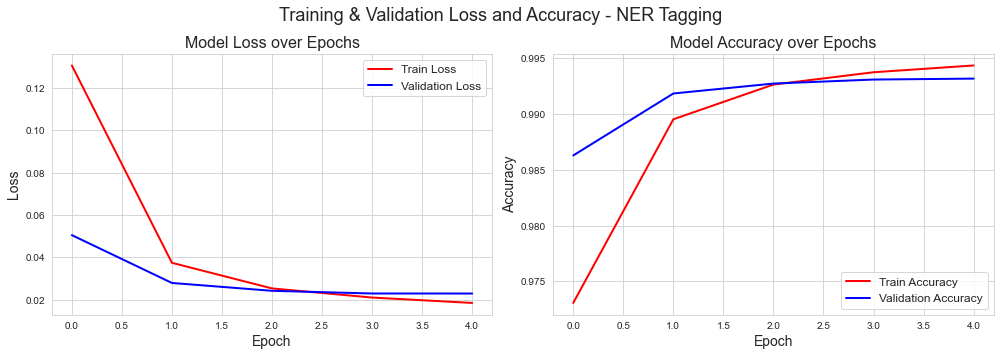

In [65]:
# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', linewidth=2, label='Train Loss')
plt.plot(val_loss, 'b', linewidth=2, label='Validation Loss')
plt.title('Model Loss over Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', linewidth=2, label='Train Accuracy')
plt.plot(val_accuracy, 'b', linewidth=2, label='Validation Accuracy')
plt.title('Model Accuracy over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('Training & Validation Loss and Accuracy - NER Tagging', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [66]:
# Predicting tags for the validation set
predictions = model.predict(X_val)

# Converting the predictions to tag indices
pred = np.argmax(predictions, axis=-1)
y_true = np.argmax(Y_val, -1)

# Converting indices to actual tags
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_true_tag = [[idx2tag[i] for i in row] for row in y_true] 

In [67]:
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

from seqeval.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_true_tag, pred_tag))


Classification Report:
               precision    recall  f1-score   support

         art       0.00      0.00      0.00        92
         eve       0.90      0.17      0.29        52
         geo       0.84      0.87      0.86      7549
         gpe       0.96      0.93      0.95      3188
         nat       0.00      0.00      0.00        44
         org       0.69      0.66      0.67      3891
         per       0.71      0.69      0.70      3347
         tim       0.86      0.83      0.84      4033

   micro avg       0.82      0.80      0.81     22196
   macro avg       0.62      0.52      0.54     22196
weighted avg       0.81      0.80      0.81     22196



In [68]:
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn_crfsuite.metrics import flat_classification_report

# Generate the flat classification report
bilstm_report = flat_classification_report(y_pred=pred_tag, y_true=y_true_tag, zero_division=1)
print(bilstm_report)

              precision    recall  f1-score   support

       B-art       1.00      0.00      0.00        92
       B-eve       0.90      0.17      0.29        52
       B-geo       0.86      0.88      0.87      7549
       B-gpe       0.97      0.94      0.95      3188
       B-nat       1.00      0.00      0.00        44
       B-org       0.80      0.71      0.75      3891
       B-per       0.84      0.78      0.81      3347
       B-tim       0.91      0.86      0.88      4033
       I-art       1.00      0.00      0.00        65
       I-eve       1.00      0.00      0.00        47
       I-geo       0.83      0.76      0.79      1479
       I-gpe       0.89      0.53      0.67        32
       I-nat       1.00      0.00      0.00        11
       I-org       0.81      0.76      0.78      3165
       I-per       0.87      0.82      0.85      3443
       I-tim       0.89      0.64      0.75      1247
           O       1.00      1.00      1.00    965779

    accuracy              

In [69]:
#predicted tags for the sample sentence
predictions = model.predict(X_test_sentence)
predicted_tags_indices = np.argmax(predictions, axis=-1)[0]
predicted_tags = [idx2tag[index] for index in predicted_tags_indices]

for word, tag in zip(tokenized_sample_sentence, predicted_tags):
    print(f"{word} - {tag}")

Barack - B-per
Obama - I-per
visited - O
London - B-geo
in - O
2015 - B-tim
and - O
spoke - O
at - O
the - O
University - B-org
of - I-org
Cambridge - I-org
. - O


- #### POS Tagging

In [70]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, Bidirectional, TimeDistributed, Dropout

# Model architecture
input = Input(shape=(input_length,))

# Embedding layer converts word indices to dense vectors of fixed size
model2 = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(input)

# Dropout layer to prevent overfitting
model2 = Dropout(0.5)(model2)

# Adding a Bidirectional LSTM layer to learn from both forward and backward sequences
model2 = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model2)

# Adding a TimeDistributed Dense layer to predict a POS tag for each token in the sequence
model2 = TimeDistributed(Dense(n_tags_pos, activation="softmax"))(model2)

# Finalize the model
model2 = Model(input, model2)

# Compiling the model with categorical crossentropy loss function for multi-class classification and using the Adam optimizer
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Display the model summary
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 104, 50)           1758500   
_________________________________________________________________
dropout_2 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 104, 200)          120800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 43)           8643      
Total params: 1,887,943
Trainable params: 1,887,943
Non-trainable params: 0
_________________________________________________________________


In [71]:
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

# Training the model with the training set, validating on 20% of the data
history2 = model2.fit(X_train, np.array(Y_train_POS), batch_size=32, epochs=5, validation_split=0.2, verbose=1)

Train on 30691 samples, validate on 7673 samples
Epoch 1/5
30691/30691 [==============================] - 105s 3ms/step - loss: 0.4130 - accuracy: 0.8967 - val_loss: 0.0736 - val_accuracy: 0.9824
Epoch 2/5
30691/30691 [==============================] - 102s 3ms/step - loss: 0.0504 - accuracy: 0.9873 - val_loss: 0.0265 - val_accuracy: 0.9928
Epoch 3/5
30691/30691 [==============================] - 104s 3ms/step - loss: 0.0238 - accuracy: 0.9934 - val_loss: 0.0201 - val_accuracy: 0.9942
Epoch 4/5
30691/30691 [==============================] - 103s 3ms/step - loss: 0.0166 - accuracy: 0.9952 - val_loss: 0.0181 - val_accuracy: 0.9947
Epoch 5/5
30691/30691 [==============================] - 105s 3ms/step - loss: 0.0134 - accuracy: 0.9959 - val_loss: 0.0170 - val_accuracy: 0.9950


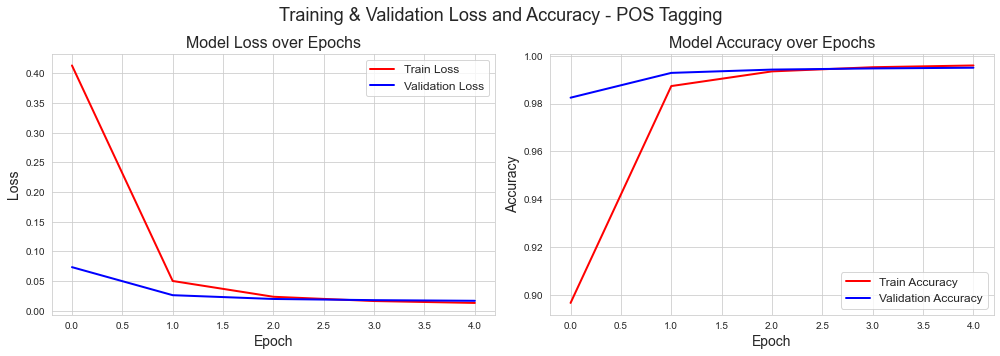

In [72]:
# Extract training history
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
train_accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']

plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_loss2, 'r', linewidth=2, label='Train Loss')
plt.plot(val_loss2, 'b', linewidth=2, label='Validation Loss')
plt.title('Model Loss over Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracy2, 'r', linewidth=2, label='Train Accuracy')
plt.plot(val_accuracy2, 'b', linewidth=2, label='Validation Accuracy')
plt.title('Model Accuracy over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('Training & Validation Loss and Accuracy - POS Tagging', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [73]:
# Predicting tags for the validation set
predictions2 = model2.predict(X_val)

# Converting the predictions to tag indices
pred2 = np.argmax(predictions2, axis=-1)
y_true_POS = np.argmax(Y_val_POS, -1)

# Converting indices to actual tags
pred_tag2 = [[idx2pos_tag[i] for i in row] for row in pred2]
y_true_tag2 = [[idx2pos_tag[i] for i in row] for row in y_true_POS] 

In [74]:
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn_crfsuite.metrics import flat_classification_report

# Generate the flat classification report
bilstm_report2 = flat_classification_report(y_pred=pred_tag2, y_true=y_true_tag2, zero_division=1)
print(bilstm_report2)

              precision    recall  f1-score   support

           $       1.00      1.00      1.00       205
           ,       1.00      1.00      1.00      6494
           .       1.00      1.00      1.00      9569
           :       0.78      0.79      0.79       151
           ;       1.00      1.00      1.00        37
       <PAD>       1.00      1.00      1.00    788476
          CC       1.00      1.00      1.00      4622
          CD       0.99      0.96      0.97      4877
          DT       1.00      1.00      1.00     19555
          EX       0.94      0.99      0.96       148
          IN       0.99      0.99      0.99     24196
          JJ       0.94      0.95      0.94     15793
         JJR       0.87      0.97      0.92       617
         JJS       0.98      0.96      0.97       596
         LRB       1.00      1.00      1.00       137
          MD       1.00      1.00      1.00      1374
          NN       0.97      0.96      0.97     29063
         NNP       0.96    

In [75]:
#predicted tags for the sample sentence
predictions2 = model2.predict(X_test_sentence)
predicted_tags_indices2 = np.argmax(predictions2, axis=-1)[0]
predicted_tags2 = [idx2pos_tag[index] for index in predicted_tags_indices2]

for word, pos_tag in zip(tokenized_sample_sentence, predicted_tags2):
    print(f"{word} - {pos_tag}")

Barack - NNP
Obama - NNP
visited - VBD
London - NNP
in - IN
2015 - CD
and - CC
spoke - VBD
at - IN
the - DT
University - NNP
of - IN
Cambridge - NNP
. - .


## ---- 3. BiLSTM + CRF ----

- #### NER Tagging

In [76]:
#keras-contrib package which contains the CRF layer
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\lokes\appdata\local\temp\pip-req-build-gkzz525f


  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git 'C:\Users\lokes\AppData\Local\Temp\pip-req-build-gkzz525f'


In [77]:
warnings.filterwarnings('ignore', category=UserWarning, module='keras_contrib')

from keras_contrib.layers import CRF

# Model architecture
input = Input(shape=(input_length,))

# Embedding layer converts word indices to dense vectors of fixed size
model3 = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(input)

# Dropout layer to prevent overfitting
model3 = Dropout(0.5)(model3)

# Add Bidirectional LSTM layer to capture forward and backward context
model3 = Bidirectional(LSTM(units=200, return_sequences=True, recurrent_dropout=0.1))(model3)

# Adding CRF layer instead of Dense layer for better sequence labeling
crf = CRF(n_tags)  # CRF layer
out = crf(model3)  # Output

# Finalize the model
model3 = Model(input, out)

# Compile the model; the CRF layer provides its own loss function and accuracy metric
model3.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])

# Display the model summary
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 104, 50)           1758500   
_________________________________________________________________
dropout_3 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 104, 400)          401600    
_________________________________________________________________
crf_1 (CRF)                  (None, 104, 17)           7140      
Total params: 2,167,240
Trainable params: 2,167,240
Non-trainable params: 0
_________________________________________________________________


In [78]:
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

# Train the model on the training data
history3 = model3.fit(X_train, np.array(Y_train), batch_size=32, epochs=5, validation_split=0.2, verbose=1)

Train on 30691 samples, validate on 7673 samples
Epoch 1/5
30691/30691 [==============================] - 256s 8ms/step - loss: 0.1074 - crf_viterbi_accuracy: 0.9720 - val_loss: 0.0328 - val_crf_viterbi_accuracy: 0.9880
Epoch 2/5
30691/30691 [==============================] - 253s 8ms/step - loss: 0.0179 - crf_viterbi_accuracy: 0.9905 - val_loss: 0.0057 - val_crf_viterbi_accuracy: 0.9925
Epoch 3/5
30691/30691 [==============================] - 255s 8ms/step - loss: -0.0013 - crf_viterbi_accuracy: 0.9932 - val_loss: -0.0064 - val_crf_viterbi_accuracy: 0.9932
Epoch 4/5
30691/30691 [==============================] - 255s 8ms/step - loss: -0.0140 - crf_viterbi_accuracy: 0.9941 - val_loss: -0.0167 - val_crf_viterbi_accuracy: 0.9932
Epoch 5/5
30691/30691 [==============================] - 256s 8ms/step - loss: -0.0251 - crf_viterbi_accuracy: 0.9946 - val_loss: -0.0268 - val_crf_viterbi_accuracy: 0.9933


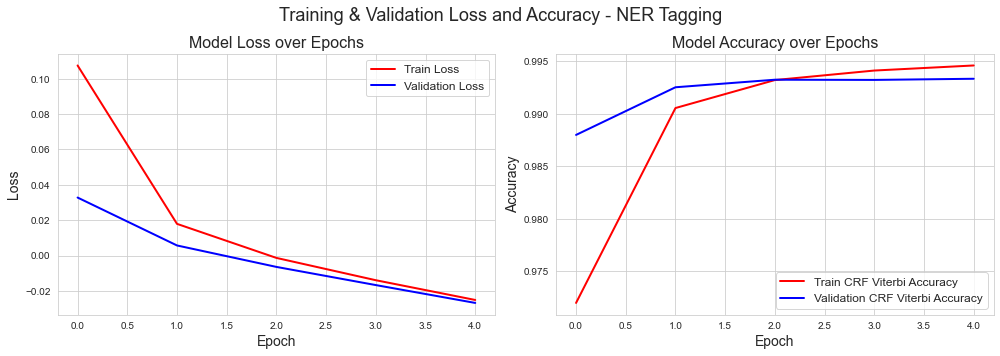

In [79]:
# Extract training history
train_loss_model3 = history3.history['loss']
val_loss_model3 = history3.history['val_loss']
train_accuracy_model3 = history3.history['crf_viterbi_accuracy']
val_accuracy_model3 = history3.history['val_crf_viterbi_accuracy']

plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_loss_model3, 'r', linewidth=2, label='Train Loss')
plt.plot(val_loss_model3, 'b', linewidth=2, label='Validation Loss')
plt.title('Model Loss over Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_model3, 'r', linewidth=2, label='Train CRF Viterbi Accuracy')
plt.plot(val_accuracy_model3, 'b', linewidth=2, label='Validation CRF Viterbi Accuracy')
plt.title('Model Accuracy over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('Training & Validation Loss and Accuracy - NER Tagging', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [80]:
# Predict on the validation set
predictions_model3 = model3.predict(X_val)

# Convert predictions and true labels from numerical form to actual tags
pred_model3 = np.argmax(predictions_model3, axis=-1)
y_true_model3 = np.argmax(Y_val, -1)

pred_tag_model3 = [[idx2tag[i] for i in row] for row in pred_model3]
y_true_tag_model3 = [[idx2tag[i] for i in row] for row in y_true_model3] 

In [81]:
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

from seqeval.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_true_tag_model3, pred_tag_model3))


Classification Report:
               precision    recall  f1-score   support

         art       0.00      0.00      0.00        92
         eve       0.00      0.00      0.00        52
         geo       0.85      0.88      0.87      7549
         gpe       0.97      0.93      0.95      3188
         nat       0.00      0.00      0.00        44
         org       0.71      0.70      0.71      3891
         per       0.79      0.71      0.75      3347
         tim       0.87      0.86      0.87      4033

   micro avg       0.84      0.82      0.83     22196
   macro avg       0.53      0.51      0.52     22196
weighted avg       0.83      0.82      0.83     22196



In [82]:
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn_crfsuite.metrics import flat_classification_report

# Generate the flat classification report
bilstm_crf_report = flat_classification_report(y_pred=pred_tag_model3, y_true=y_true_tag_model3, zero_division=1)
print(bilstm_crf_report)

              precision    recall  f1-score   support

       B-art       1.00      0.00      0.00        92
       B-eve       1.00      0.00      0.00        52
       B-geo       0.86      0.89      0.88      7549
       B-gpe       0.97      0.93      0.95      3188
       B-nat       1.00      0.00      0.00        44
       B-org       0.74      0.74      0.74      3891
       B-per       0.86      0.77      0.81      3347
       B-tim       0.90      0.88      0.89      4033
       I-art       1.00      0.00      0.00        65
       I-eve       1.00      0.00      0.00        47
       I-geo       0.82      0.77      0.80      1479
       I-gpe       0.96      0.75      0.84        32
       I-nat       1.00      0.00      0.00        11
       I-org       0.73      0.82      0.77      3165
       I-per       0.89      0.81      0.85      3443
       I-tim       0.79      0.76      0.78      1247
           O       1.00      1.00      1.00    965779

    accuracy              

In [83]:
#predicted tags for the sample sentence
predictions = model3.predict(X_test_sentence)
predicted_tags_indices = np.argmax(predictions, axis=-1)[0]
predicted_tags = [idx2tag[index] for index in predicted_tags_indices]

for word, tag in zip(tokenized_sample_sentence, predicted_tags):
    print(f"{word} - {tag}")

Barack - B-per
Obama - I-per
visited - O
London - B-geo
in - O
2015 - B-tim
and - O
spoke - O
at - O
the - O
University - B-org
of - I-org
Cambridge - I-org
. - O


- #### POS Tagging

In [84]:
warnings.filterwarnings('ignore', category=UserWarning, module='keras_contrib')

from keras_contrib.layers import CRF

# Model architecture
input = Input(shape=(input_length,))

# Embedding layer converts word indices to dense vectors of fixed size
model4 = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(input)

# Dropout layer to prevent overfitting
model4 = Dropout(0.5)(model4)

# Add Bidirectional LSTM layer to capture forward and backward context
model4 = Bidirectional(LSTM(units=200, return_sequences=True, recurrent_dropout=0.1))(model4)

# Adding CRF layer instead of Dense layer for better sequence labeling
crf = CRF(n_tags_pos)  # CRF layer
out = crf(model4)  # Output

# Finalize the model
model4 = Model(input, out)

# Compile the model; the CRF layer provides its own loss function and accuracy metric
model4.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])

# Display the model summary
model4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 104, 50)           1758500   
_________________________________________________________________
dropout_4 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 104, 400)          401600    
_________________________________________________________________
crf_2 (CRF)                  (None, 104, 43)           19178     
Total params: 2,179,278
Trainable params: 2,179,278
Non-trainable params: 0
_________________________________________________________________


In [85]:
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

# Train the model on the training data
history4 = model4.fit(X_train, np.array(Y_train_POS), batch_size=32, epochs=5, validation_split=0.2, verbose=1)

Train on 30691 samples, validate on 7673 samples
Epoch 1/5
30691/30691 [==============================] - 279s 9ms/step - loss: 0.3535 - crf_viterbi_accuracy: 0.9019 - val_loss: 0.0440 - val_crf_viterbi_accuracy: 0.9868
Epoch 2/5
30691/30691 [==============================] - 276s 9ms/step - loss: 0.0262 - crf_viterbi_accuracy: 0.9894 - val_loss: 0.0041 - val_crf_viterbi_accuracy: 0.9935
Epoch 3/5
30691/30691 [==============================] - 275s 9ms/step - loss: -0.0027 - crf_viterbi_accuracy: 0.9941 - val_loss: -0.0094 - val_crf_viterbi_accuracy: 0.9945
Epoch 4/5
30691/30691 [==============================] - 273s 9ms/step - loss: -0.0177 - crf_viterbi_accuracy: 0.9956 - val_loss: -0.0201 - val_crf_viterbi_accuracy: 0.9948
Epoch 5/5
30691/30691 [==============================] - 276s 9ms/step - loss: -0.0296 - crf_viterbi_accuracy: 0.9962 - val_loss: -0.0303 - val_crf_viterbi_accuracy: 0.9951


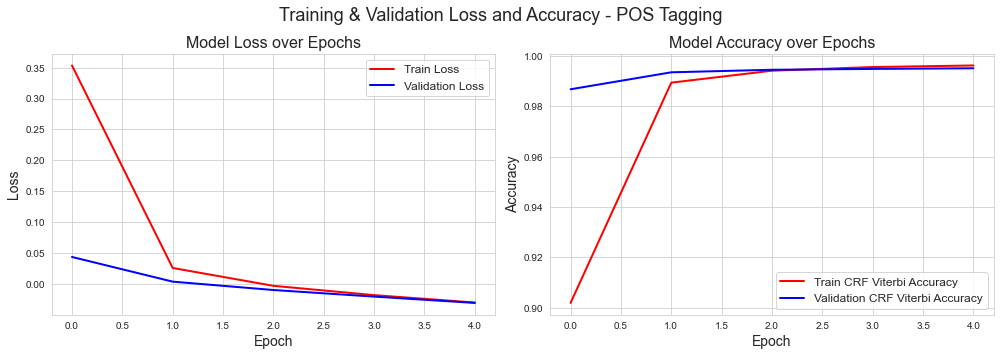

In [86]:
# Extract training history
train_loss_model4 = history4.history['loss']
val_loss_model4 = history4.history['val_loss']
train_accuracy_model4 = history4.history['crf_viterbi_accuracy']
val_accuracy_model4 = history4.history['val_crf_viterbi_accuracy']

plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_loss_model4, 'r', linewidth=2, label='Train Loss')
plt.plot(val_loss_model4, 'b', linewidth=2, label='Validation Loss')
plt.title('Model Loss over Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_model4, 'r', linewidth=2, label='Train CRF Viterbi Accuracy')
plt.plot(val_accuracy_model4, 'b', linewidth=2, label='Validation CRF Viterbi Accuracy')
plt.title('Model Accuracy over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('Training & Validation Loss and Accuracy - POS Tagging', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [87]:
# Predict on the validation set
predictions_model4 = model4.predict(X_val)

# Convert predictions and true labels from numerical form to actual tags
pred_model4 = np.argmax(predictions_model4, axis=-1)
y_true_model4 = np.argmax(Y_val_POS, -1)

pred_tag_model4 = [[idx2pos_tag[i] for i in row] for row in pred_model4]
y_true_tag_model4 = [[idx2pos_tag[i] for i in row] for row in y_true_model4] 

In [88]:
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn_crfsuite.metrics import flat_classification_report

# Generate the flat classification report
bilstm_crf_report_pos = flat_classification_report(y_pred=pred_tag_model4, y_true=y_true_tag_model4, zero_division=1)
print(bilstm_crf_report_pos)

              precision    recall  f1-score   support

           $       1.00      1.00      1.00       205
           ,       1.00      1.00      1.00      6494
           .       1.00      1.00      1.00      9569
           :       0.81      0.80      0.80       151
           ;       0.97      1.00      0.99        37
       <PAD>       1.00      1.00      1.00    788476
          CC       1.00      1.00      1.00      4622
          CD       0.99      0.96      0.97      4877
          DT       1.00      1.00      1.00     19555
          EX       0.94      0.99      0.96       148
          IN       0.99      0.99      0.99     24196
          JJ       0.94      0.95      0.95     15793
         JJR       0.94      0.95      0.94       617
         JJS       0.98      0.96      0.97       596
         LRB       1.00      1.00      1.00       137
          MD       1.00      1.00      1.00      1374
          NN       0.96      0.97      0.97     29063
         NNP       0.97    

In [89]:
#predicted tags for the sample sentence
predictions = model4.predict(X_test_sentence)
predicted_tags_indices = np.argmax(predictions, axis=-1)[0]
predicted_tags = [idx2pos_tag[index] for index in predicted_tags_indices]

for word, pos_tag in zip(tokenized_sample_sentence, predicted_tags):
    print(f"{word} - {pos_tag}")

Barack - NNP
Obama - NNP
visited - VBD
London - NNP
in - IN
2015 - CD
and - CC
spoke - VBD
at - IN
the - DT
University - NNP
of - IN
Cambridge - NNP
. - .


## ---- 4. CNN Model for Sequence Tagging ----

- #### NER Tagging

In [90]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, TimeDistributed, Dense, Dropout

input_dim = len(word2idx)  # Vocabulary size
embedding_dim = 128
output_dim = len(tag2idx)  # Number of tags
num_filters = 64
kernel_size = 3

# Input layer
input_layer = Input(shape=(MAX_LEN,))

# Embedding layer
embedding_layer = Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=MAX_LEN)(input_layer)

# Add a convolutional layer with specified number of filters and kernel size
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same')(embedding_layer)
dropout_conv = Dropout(0.5)(conv_layer)

# Use a TimeDistributed layer to apply a dense layer to each time step independently
time_distributed = TimeDistributed(Dense(output_dim, activation='softmax'))(dropout_conv)

# Finalize the model with inputs and outputs specified
model_CNN = Model(inputs=input_layer, outputs=time_distributed)

# Compile the model with the adam optimizer and categorical crossentropy as the loss function
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_CNN.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 104, 128)          4501760   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 104, 64)           24640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 104, 64)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 104, 17)           1105      
Total params: 4,527,505
Trainable params: 4,527,505
Non-trainable params: 0
_________________________________________________________________


In [91]:
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

# Train the model on the training data
history5 = model_CNN.fit(X_train, np.array(Y_train), batch_size=32, epochs=5, validation_data=(X_val, np.array(Y_val)), verbose=1)

Train on 38364 samples, validate on 9591 samples
Epoch 1/5
38364/38364 [==============================] - 70s 2ms/step - loss: 0.1156 - accuracy: 0.9820 - val_loss: 0.0263 - val_accuracy: 0.9923
Epoch 2/5
38364/38364 [==============================] - 69s 2ms/step - loss: 0.0261 - accuracy: 0.9928 - val_loss: 0.0237 - val_accuracy: 0.9929
Epoch 3/5
38364/38364 [==============================] - 72s 2ms/step - loss: 0.0208 - accuracy: 0.9940 - val_loss: 0.0237 - val_accuracy: 0.9930
Epoch 4/5
38364/38364 [==============================] - 71s 2ms/step - loss: 0.0180 - accuracy: 0.9946 - val_loss: 0.0243 - val_accuracy: 0.9930
Epoch 5/5
38364/38364 [==============================] - 72s 2ms/step - loss: 0.0163 - accuracy: 0.9950 - val_loss: 0.0253 - val_accuracy: 0.9929


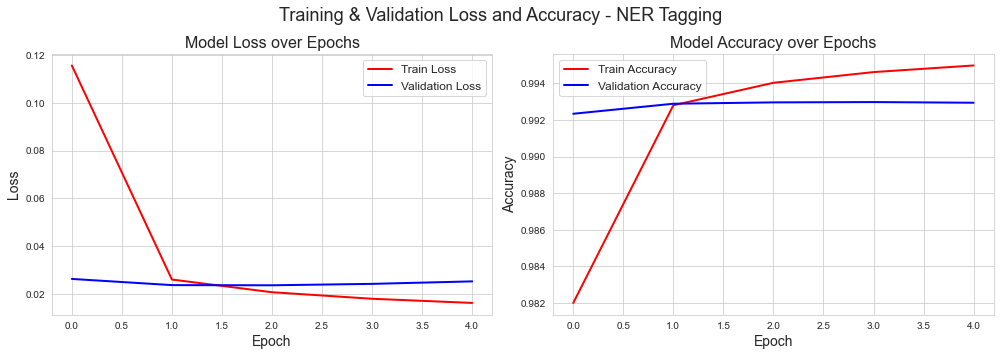

In [92]:
# Extract training history
train_loss_CNN = history5.history['loss']
val_loss_CNN = history5.history['val_loss']
train_accuracy_CNN = history5.history['accuracy']
val_accuracy_CNN = history5.history['val_accuracy']

plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_loss_CNN, 'r', linewidth=2, label='Train Loss')
plt.plot(val_loss_CNN, 'b', linewidth=2, label='Validation Loss')
plt.title('Model Loss over Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_CNN, 'r', linewidth=2, label='Train Accuracy')
plt.plot(val_accuracy_CNN, 'b', linewidth=2, label='Validation Accuracy')
plt.title('Model Accuracy over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('Training & Validation Loss and Accuracy - NER Tagging', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [93]:
# Make predictions on the validation set
predictions_CNN = model_CNN.predict(X_val)

# Convert predictions and true values to tag sequences
pred_CNN = np.argmax(predictions_CNN, axis=-1)
y_true_CNN = np.argmax(Y_val, -1)

pred_tag_CNN = [[idx2tag[i] for i in row] for row in pred_CNN]
y_true_tag_CNN = [[idx2tag[i] for i in row] for row in y_true_CNN] 

In [94]:
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

print("\nClassification Report:\n", classification_report(y_true_tag_CNN, pred_tag_CNN))


Classification Report:
               precision    recall  f1-score   support

         art       0.00      0.00      0.00        92
         eve       0.53      0.17      0.26        52
         geo       0.82      0.89      0.85      7549
         gpe       0.96      0.94      0.95      3188
         nat       1.00      0.02      0.04        44
         org       0.62      0.65      0.63      3891
         per       0.69      0.70      0.70      3347
         tim       0.84      0.85      0.84      4033

   micro avg       0.79      0.81      0.80     22196
   macro avg       0.68      0.53      0.54     22196
weighted avg       0.78      0.81      0.80     22196



In [95]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Generate the flat classification report
report_CNN = flat_classification_report(y_pred=pred_tag_CNN, y_true=y_true_tag_CNN, zero_division=1)
print(report_CNN)

              precision    recall  f1-score   support

       B-art       1.00      0.00      0.00        92
       B-eve       0.60      0.17      0.27        52
       B-geo       0.84      0.90      0.87      7549
       B-gpe       0.97      0.95      0.96      3188
       B-nat       1.00      0.02      0.04        44
       B-org       0.76      0.71      0.73      3891
       B-per       0.83      0.79      0.81      3347
       B-tim       0.90      0.88      0.89      4033
       I-art       1.00      0.00      0.00        65
       I-eve       0.50      0.02      0.04        47
       I-geo       0.84      0.73      0.78      1479
       I-gpe       1.00      0.59      0.75        32
       I-nat       1.00      0.00      0.00        11
       I-org       0.76      0.73      0.75      3165
       I-per       0.86      0.82      0.84      3443
       I-tim       0.79      0.70      0.74      1247
           O       1.00      1.00      1.00    965779

    accuracy              

In [96]:
predictions = model_CNN.predict(X_test_sentence)
predicted_tags_indices = np.argmax(predictions, axis=-1)[0]
predicted_tags = [idx2tag[index] for index in predicted_tags_indices]

# 5. Display the tokenized sentence alongside its predicted tags
for word, tag in zip(tokenized_sample_sentence, predicted_tags):
    print(f"{word} - {tag}")

Barack - B-per
Obama - I-per
visited - O
London - B-geo
in - O
2015 - B-tim
and - O
spoke - O
at - O
the - O
University - B-org
of - I-org
Cambridge - B-geo
. - O


- #### POS Tagging

In [97]:
input_dim = len(word2idx)  # Vocabulary size
embedding_dim = 128
output_dim = len(pos_tag2idx)  # Number of POS tags
num_filters = 64
kernel_size = 3

# Input layer
input_layer = Input(shape=(MAX_LEN,))

# Embedding layer
embedding_layer = Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=MAX_LEN)(input_layer)

# Add a convolutional layer with specified number of filters and kernel size
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same')(embedding_layer)
dropout_conv = Dropout(0.5)(conv_layer)

# Use a TimeDistributed layer to apply a dense layer to each time step independently
time_distributed = TimeDistributed(Dense(output_dim, activation='softmax'))(dropout_conv)

# Finalize the model with inputs and outputs specified
model_CNN2 = Model(inputs=input_layer, outputs=time_distributed)

# Compile the model with the adam optimizer and categorical crossentropy as the loss function
model_CNN2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_CNN2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 104, 128)          4501760   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 104, 64)           24640     
_________________________________________________________________
dropout_6 (Dropout)          (None, 104, 64)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 104, 43)           2795      
Total params: 4,529,195
Trainable params: 4,529,195
Non-trainable params: 0
_________________________________________________________________


In [98]:
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

# Train the model on the training data
history6 = model_CNN2.fit(X_train, np.array(Y_train_POS), batch_size=32, epochs=5, validation_data=(X_val, np.array(Y_val_POS)), verbose=1)

Train on 38364 samples, validate on 9591 samples
Epoch 1/5
38364/38364 [==============================] - 72s 2ms/step - loss: 0.2108 - accuracy: 0.9643 - val_loss: 0.0222 - val_accuracy: 0.9938
Epoch 2/5
38364/38364 [==============================] - 71s 2ms/step - loss: 0.0232 - accuracy: 0.9940 - val_loss: 0.0164 - val_accuracy: 0.9949
Epoch 3/5
38364/38364 [==============================] - 72s 2ms/step - loss: 0.0146 - accuracy: 0.9959 - val_loss: 0.0159 - val_accuracy: 0.9952
Epoch 4/5
38364/38364 [==============================] - 70s 2ms/step - loss: 0.0115 - accuracy: 0.9966 - val_loss: 0.0163 - val_accuracy: 0.9953
Epoch 5/5
38364/38364 [==============================] - 71s 2ms/step - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.0166 - val_accuracy: 0.9953


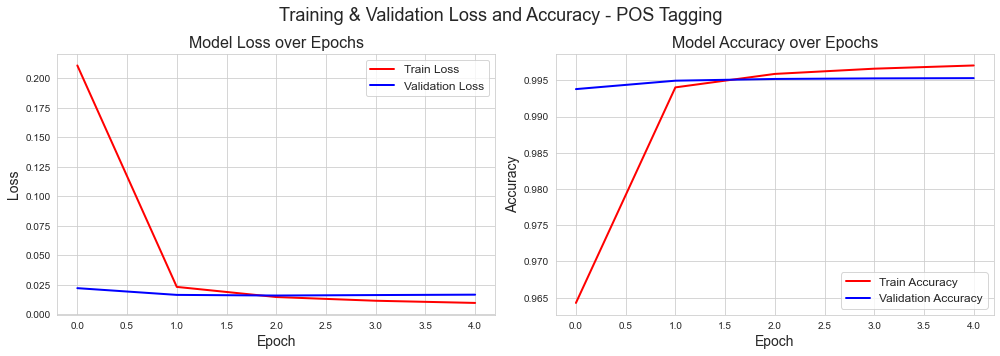

In [99]:
# Extract training history
train_loss_CNN2 = history6.history['loss']
val_loss_CNN2 = history6.history['val_loss']
train_accuracy_CNN2 = history6.history['accuracy']
val_accuracy_CNN2 = history6.history['val_accuracy']

plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_loss_CNN2, 'r', linewidth=2, label='Train Loss')
plt.plot(val_loss_CNN2, 'b', linewidth=2, label='Validation Loss')
plt.title('Model Loss over Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_CNN2, 'r', linewidth=2, label='Train Accuracy')
plt.plot(val_accuracy_CNN2, 'b', linewidth=2, label='Validation Accuracy')
plt.title('Model Accuracy over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('Training & Validation Loss and Accuracy - POS Tagging', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [100]:
# Make predictions on the validation set
predictions_CNN2 = model_CNN2.predict(X_val)

# Convert predictions and true values to tag sequences
pred_CNN2 = np.argmax(predictions_CNN2, axis=-1)
y_true_CNN2 = np.argmax(Y_val_POS, -1)

pred_tag_CNN2 = [[idx2pos_tag[i] for i in row] for row in pred_CNN2]
y_true_tag_CNN2 = [[idx2pos_tag[i] for i in row] for row in y_true_CNN2] 

In [101]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Generate the flat classification report
report_CNN2 = flat_classification_report(y_pred=pred_tag_CNN2, y_true=y_true_tag_CNN2, zero_division=1)
print(report_CNN2)

              precision    recall  f1-score   support

           $       1.00      1.00      1.00       205
           ,       1.00      1.00      1.00      6494
           .       1.00      1.00      1.00      9569
           :       0.79      0.89      0.83       151
           ;       1.00      1.00      1.00        37
       <PAD>       1.00      1.00      1.00    788476
          CC       1.00      1.00      1.00      4622
          CD       1.00      0.97      0.98      4877
          DT       1.00      1.00      1.00     19555
          EX       0.92      0.99      0.95       148
          IN       0.99      0.99      0.99     24196
          JJ       0.95      0.95      0.95     15793
         JJR       0.90      0.98      0.93       617
         JJS       0.95      0.97      0.96       596
         LRB       1.00      1.00      1.00       137
          MD       1.00      1.00      1.00      1374
          NN       0.97      0.97      0.97     29063
         NNP       0.97    

In [102]:
predictions = model_CNN2.predict(X_test_sentence)
predicted_tags_indices = np.argmax(predictions, axis=-1)[0]
predicted_tags = [idx2pos_tag[index] for index in predicted_tags_indices]

# 5. Display the tokenized sentence alongside its predicted tags
for word, pos_tag in zip(tokenized_sample_sentence, predicted_tags):
    print(f"{word} - {pos_tag}")

Barack - NNP
Obama - NNP
visited - VBD
London - NNP
in - IN
2015 - CD
and - CC
spoke - VBD
at - IN
the - DT
University - NNP
of - IN
Cambridge - NNP
. - .


## ---- 5. Advanced Transformer Models For NER and POS tagging (XLNet & BERT) ----

**In addition to the models implemented in this notebook (CRF, CNN, BiLSTM, BiLSTM+CRF), we have also explored the use of advanced transformer models, specifically XLNet and BERT, for the NER and POS tagging tasks. Due to their high computational requirements, these two models have been implemented in a separate Jupyter notebook. This separate notebook was run on Northeastern University's On-Demand (OOD) computing cluster, where we could utilize the GPU resources effectively. This approach allowed us to manage the computational demands of these models efficiently, which was not feasible on my local machine. The other notebook is suffixed with "-LM**

## Training and Validation Performance of BiLSTM, CNN, and BiLSTM+CRF Models for NER & POS

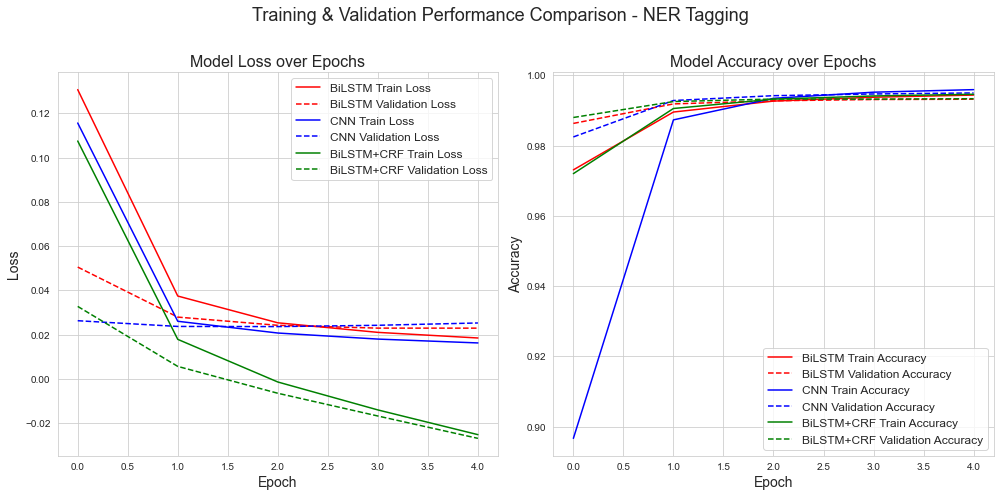

In [103]:
# Assuming history is the history object from BiLSTM training and history2 from CNN training
plt.figure(figsize=(14, 7))

# Plot training & validation loss values for BiLSTM, CNN, and BiLSTM+CRF
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r', label='BiLSTM Train Loss')
plt.plot(history.history['val_loss'], 'r--', label='BiLSTM Validation Loss')
plt.plot(history5.history['loss'], 'b', label='CNN Train Loss')
plt.plot(history5.history['val_loss'], 'b--', label='CNN Validation Loss')
plt.plot(train_loss_model3, 'g', label='BiLSTM+CRF Train Loss')
plt.plot(val_loss_model3, 'g--', label='BiLSTM+CRF Validation Loss')
plt.title('Model Loss over Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training & validation accuracy values for BiLSTM, CNN, and BiLSTM+CRF
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label='BiLSTM Train Accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='BiLSTM Validation Accuracy')
plt.plot(history2.history['accuracy'], 'b', label='CNN Train Accuracy')
plt.plot(history2.history['val_accuracy'], 'b--', label='CNN Validation Accuracy')
plt.plot(train_accuracy_model3, 'g', label='BiLSTM+CRF Train Accuracy')
plt.plot(val_accuracy_model3, 'g--', label='BiLSTM+CRF Validation Accuracy')
plt.title('Model Accuracy over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('Training & Validation Performance Comparison - NER Tagging', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


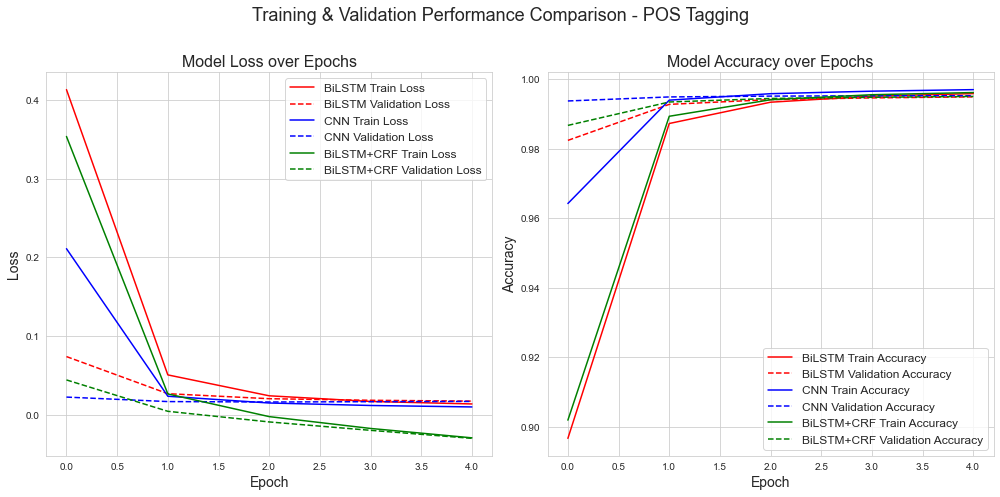

In [104]:
# Assuming history is the history object from BiLSTM training and history2 from CNN training
plt.figure(figsize=(14, 7))

# Plot training & validation loss values for BiLSTM, CNN, and BiLSTM+CRF
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], 'r', label='BiLSTM Train Loss')
plt.plot(history2.history['val_loss'], 'r--', label='BiLSTM Validation Loss')
plt.plot(history6.history['loss'], 'b', label='CNN Train Loss')
plt.plot(history6.history['val_loss'], 'b--', label='CNN Validation Loss')
plt.plot(train_loss_model4, 'g', label='BiLSTM+CRF Train Loss')
plt.plot(val_loss_model4, 'g--', label='BiLSTM+CRF Validation Loss')
plt.title('Model Loss over Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training & validation accuracy values for BiLSTM, CNN, and BiLSTM+CRF
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], 'r', label='BiLSTM Train Accuracy')
plt.plot(history2.history['val_accuracy'], 'r--', label='BiLSTM Validation Accuracy')
plt.plot(history6.history['accuracy'], 'b', label='CNN Train Accuracy')
plt.plot(history6.history['val_accuracy'], 'b--', label='CNN Validation Accuracy')
plt.plot(train_accuracy_model4, 'g', label='BiLSTM+CRF Train Accuracy')
plt.plot(val_accuracy_model4, 'g--', label='BiLSTM+CRF Validation Accuracy')
plt.title('Model Accuracy over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('Training & Validation Performance Comparison - POS Tagging', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

## ---- Performance Comparison of NLP Models Across Precision, Recall, and F1 Metrics (Including the Transformer Models) ----

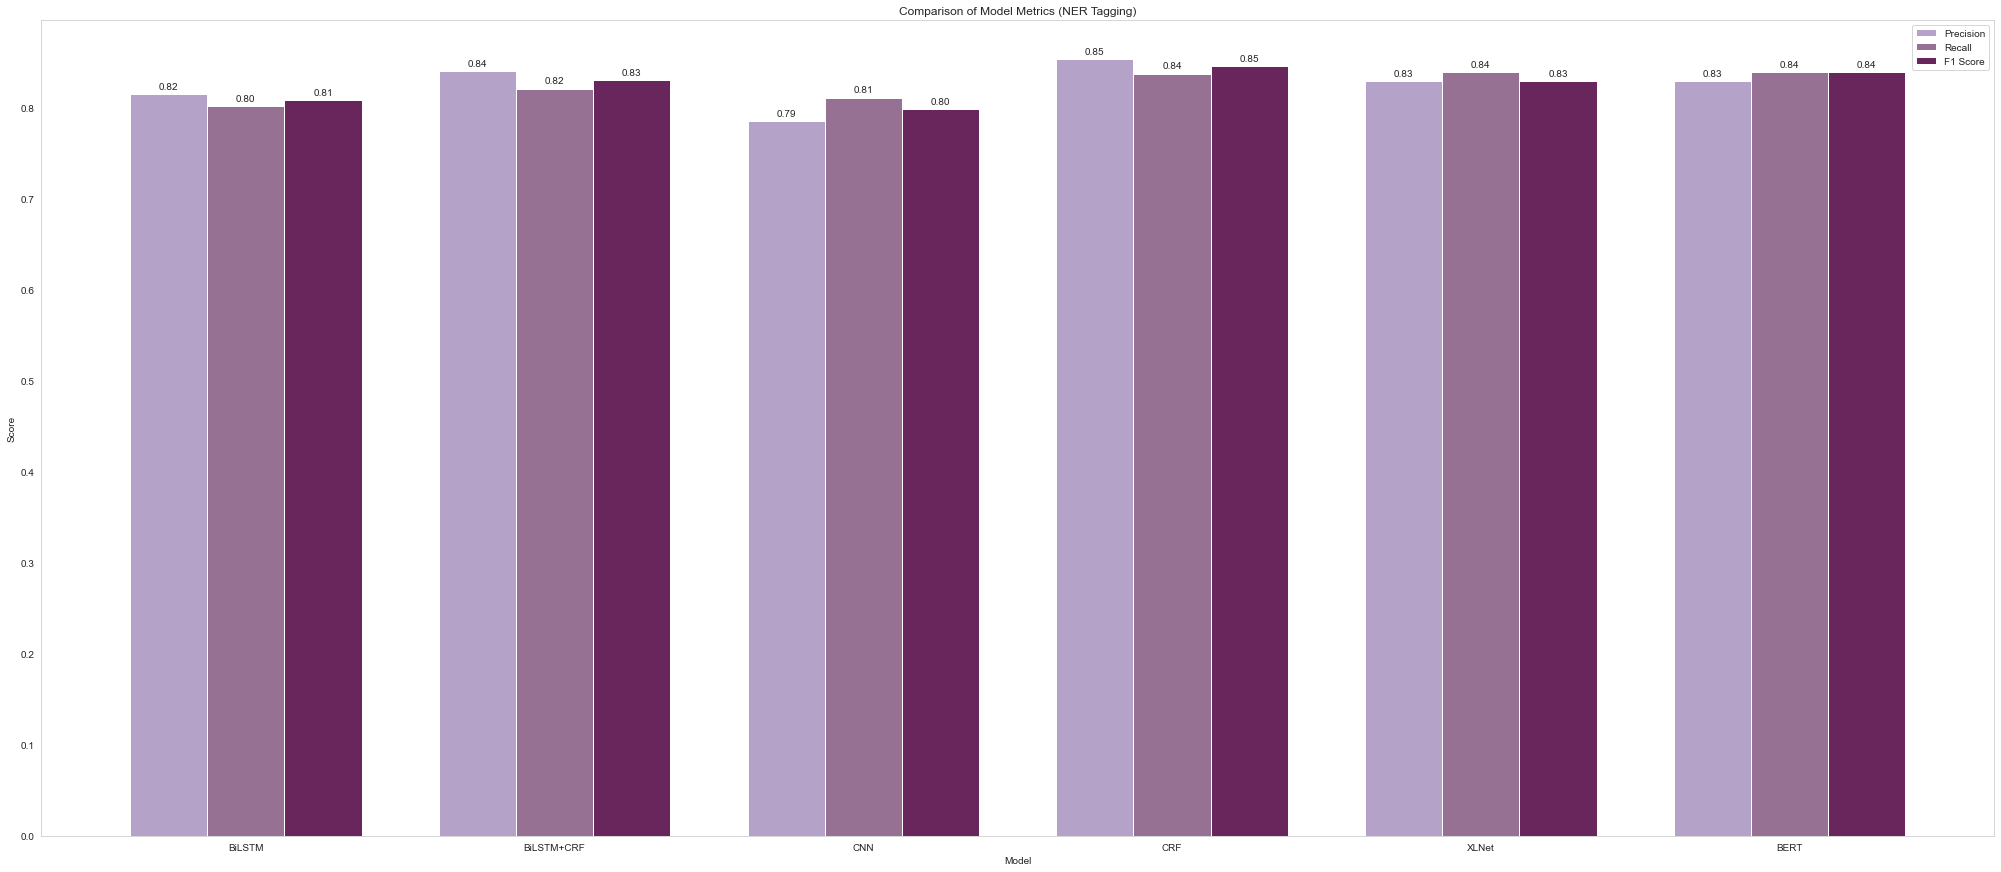

In [105]:
from seqeval.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 scores for each model
precision_crf = precision_score(y_NER_test, y_pred_crf)
recall_crf = recall_score(y_NER_test, y_pred_crf)
f1_crf = f1_score(y_NER_test, y_pred_crf)

precision_bilstm = precision_score(y_true_tag, pred_tag)
recall_bilstm = recall_score(y_true_tag, pred_tag)
f1_bilstm = f1_score(y_true_tag, pred_tag)

precision_bilstm_crf = precision_score(y_true_tag_model3, pred_tag_model3)
recall_bilstm_crf = recall_score(y_true_tag_model3, pred_tag_model3)
f1_bilstm_crf = f1_score(y_true_tag_model3, pred_tag_model3)

precision_cnn = precision_score(y_true_tag_CNN, pred_tag_CNN)
recall_cnn = recall_score(y_true_tag_CNN, pred_tag_CNN)
f1_cnn = f1_score(y_true_tag_CNN, pred_tag_CNN)

# New model (XLNet) scores
precision_xlnet = 0.83
recall_xlnet = 0.84
f1_xlnet = 0.83

# New model (BERT) scores
precision_bert = 0.83
recall_bert = 0.84
f1_bert = 0.84

# Create a DataFrame to hold these values
metrics_df = pd.DataFrame({
    'Model': ['BiLSTM', 'BiLSTM+CRF', 'CNN', 'CRF', 'XLNet', 'BERT'],
    'Precision': [precision_bilstm, precision_bilstm_crf, precision_cnn, precision_crf, precision_xlnet, precision_bert],
    'Recall': [recall_bilstm, recall_bilstm_crf, recall_cnn, recall_crf, recall_xlnet, recall_bert],
    'F1 Score': [f1_bilstm, f1_bilstm_crf, f1_cnn, f1_crf, f1_xlnet, f1_bert]
})

# Plotting with thicker bars and specific colors
positions = list(range(len(metrics_df)))
width = 0.25  # Increased bar width

# Colors for Precision, Recall, and F1 Score
color_precision = "#b5a2c8"
color_recall = "#977194"
color_f1 = "#68265c"

fig, ax = plt.subplots(figsize=(35, 15))

bars1 = plt.bar([p - width for p in positions], metrics_df['Precision'], width, color=color_precision, label='Precision')
bars2 = plt.bar(positions, metrics_df['Recall'], width, color=color_recall, label='Recall')
bars3 = plt.bar([p + width for p in positions], metrics_df['F1 Score'], width, color=color_f1, label='F1 Score')

ax.set_xticks(positions)
ax.set_xticklabels(metrics_df['Model'])

# Function to attach a text label above each bar displaying its height
def attach_values_to_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function for each set of bars
attach_values_to_bars(bars1)
attach_values_to_bars(bars2)
attach_values_to_bars(bars3)

plt.ylabel('Score')
plt.xlabel('Model')
plt.title('Comparison of Model Metrics (NER Tagging)')
plt.legend()
plt.grid()
plt.show()

### Model Performance Analysis for NER Tagging:

### BiLSTM (Bidirectional Long Short-Term Memory)
- **Precision**: At 0.82, indicates that it correctly labels entities 81% of the time.
- **Recall**: A recall of 0.80 shows it can find most relevant instances within a dataset.
- **F1 Score**: The balanced score of 0.81 suggests overall good performance.

### BiLSTM+CRF (Bidirectional Long Short-Term Memory with Conditional Random Fields)
- **Precision**: Improved precision at 0.84 due to the CRF enhancement.
- **Recall**: High recall of 0.82, capturing a large proportion of actual positives.
- **F1 Score**: An F1 score of 0.83 reflects high precision and recall, making this model very reliable.

### CNN (Convolutional Neural Network)
- **Precision**: Slightly lower precision at 0.79 compared to LSTM-based models.
- **Recall**: A solid recall of 0.81, indicating good coverage in identifying true positives.
- **F1 Score**: An F1 score of 0.80 signifies a balanced precision-recall trade-off.

### CRF (Conditional Random Fields)
- **Precision**: Highest precision at 0.85 suggests very accurate predictions.
- **Recall**: High recall of 0.84, missing few actual positives.
- **F1 Score**: The top F1 score of 0.85 indicates an excellent precision-recall balance.

### XLNet
- **Precision**: Precision of 0.83 shows high accuracy in labeling entities.
- **Recall**: A recall of 0.84 slightly outperforms BiLSTM models.
- **F1 Score**: The F1 score of 0.83 points to strong performance with balanced precision and recall.

### BERT
- **Precision**: High precision of 0.83, matching XLNet in accuracy.
- **Recall**: Equal recall of 0.84, suggesting good entity coverage.
- **F1 Score**: A slightly better F1 score of 0.84 than XLNet, suggesting marginal overall superiority.

**Summary**: The CRF model exhibits the best precision and F1 score, potentially making it the best overall model. XLNet and BERT also show very close performance, with minor differences, and could be preferred for deep learning model requirements. The BiLSTM+CRF model also demonstrates strong performance, particularly in precision. The CNN and BiLSTM models perform well but are slightly outperformed by the other models in this comparison.



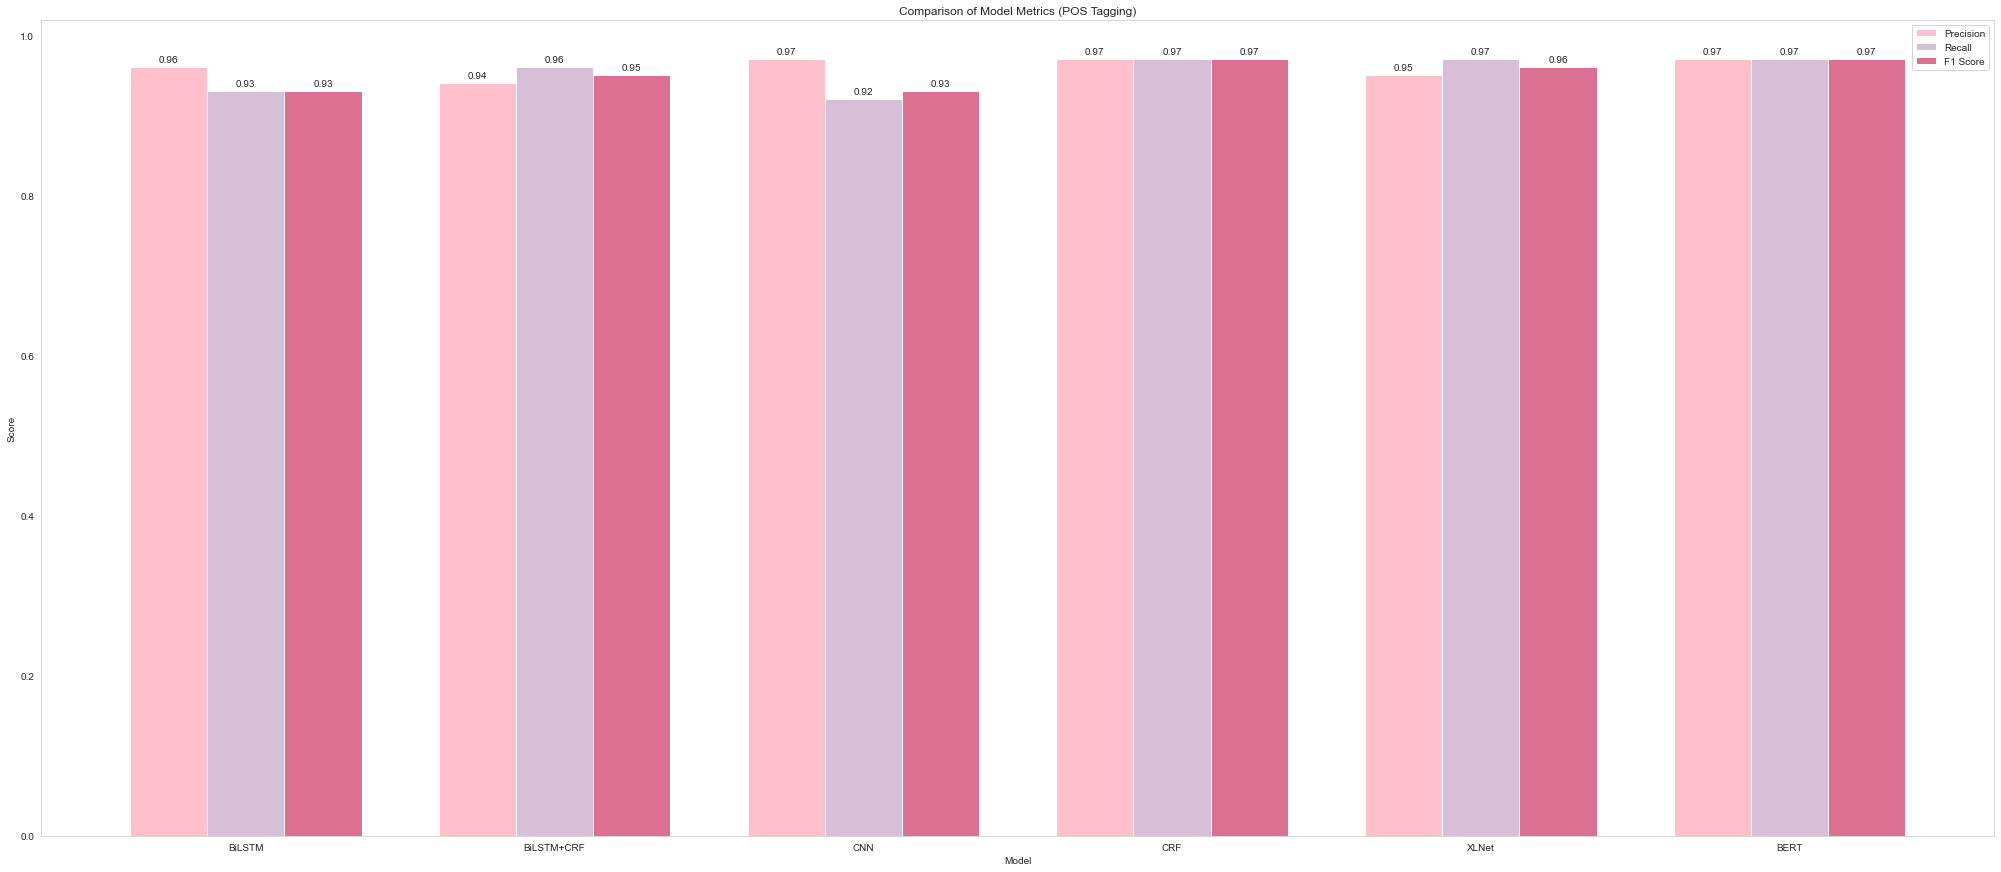

In [106]:
def extract_metrics(report):
    # Split the report into lines
    lines = report.split('\n')

    # Iterate through lines to find the average scores
    for line in lines:
        if 'avg / total' in line or 'micro avg' in line or 'macro avg' in line or 'weighted avg' in line:
            # Split the line into components
            parts = line.split()

            # Extract the metrics
            precision = float(parts[-4])
            recall = float(parts[-3])
            f1_score = float(parts[-2])

            # Return the extracted values
            return precision, recall, f1_score

precision_crf, recall_crf, f1_crf = extract_metrics(crf_POS_report)
precision_bilstm, recall_bilstm, f1_bilstm = extract_metrics(bilstm_report2)
precision_bilstm_crf, recall_bilstm_crf, f1_bilstm_crf = extract_metrics(bilstm_crf_report_pos)
precision_cnn, recall_cnn, f1_cnn = extract_metrics(report_CNN2)

# New model (XLNet) scores
precision_xlnet = 0.95
recall_xlnet = 0.97
f1_xlnet = 0.96

# New model (BERT) scores
precision_bert = 0.97
recall_bert = 0.97
f1_bert = 0.97

# Creating a DataFrame for the data
metrics_df = pd.DataFrame({
    'Model': ['BiLSTM', 'BiLSTM+CRF', 'CNN', 'CRF', 'XLNet', 'BERT'],
    'Precision': [precision_bilstm, precision_bilstm_crf, precision_cnn, precision_crf, precision_xlnet, precision_bert],
    'Recall': [recall_bilstm, recall_bilstm_crf, recall_cnn, recall_crf, recall_xlnet, recall_bert],
    'F1 Score': [f1_bilstm, f1_bilstm_crf, f1_cnn, f1_crf, f1_xlnet, f1_bert]
})

# Plotting with values displayed on bars
positions = list(range(len(metrics_df)))
width = 0.25

fig, ax = plt.subplots(figsize=(35, 15))

colors = ['#FFC0CB', '#D8BFD8', '#DB7093']
bars1 = plt.bar([p - width for p in positions], metrics_df['Precision'], width, color=colors[0], label='Precision')
bars2 = plt.bar(positions, metrics_df['Recall'], width, color=colors[1], label='Recall')
bars3 = plt.bar([p + width for p in positions], metrics_df['F1 Score'], width, color=colors[2], label='F1 Score')

ax.set_xticks(positions)
ax.set_xticklabels(metrics_df['Model'])

# Function to attach a text label above each bar displaying its height
def attach_values_to_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function for each set of bars
attach_values_to_bars(bars1)
attach_values_to_bars(bars2)
attach_values_to_bars(bars3)

plt.ylabel('Score')
plt.xlabel('Model')
plt.title('Comparison of Model Metrics (POS Tagging)')
plt.legend()
plt.grid()
plt.show()

## Model Performance Analysis for POS Tagging

### BiLSTM (Bidirectional Long Short-Term Memory)
- **Precision**: High precision of 0.96 shows that BiLSTM is very accurate in predicting the correct tags.
- **Recall**: A recall of 0.93 indicates it identifies 93% of all actual instances correctly.
- **F1 Score**: An F1 score of 0.93 demonstrates a strong balance between precision and recall.

### BiLSTM+CRF (Bidirectional Long Short-Term Memory with Conditional Random Fields)
- **Precision**: A precision of 0.94 signifies a high level of tagging accuracy.
- **Recall**: The recall score of 0.96 is excellent, indicating that it captures a high proportion of actual positive instances.
- **F1 Score**: With an F1 score of 0.95, BiLSTM+CRF shows a very good precision-recall balance, slightly better than BiLSTM alone.

### CNN (Convolutional Neural Network)
- **Precision**: The CNN model tops the precision metric at 0.97, indicating very accurate predictions.
- **Recall**: A recall of 0.92 suggests that while precise, it may miss some positive instances.
- **F1 Score**: An F1 score of 0.93 points to a good trade-off between precision and recall.

### CRF (Conditional Random Fields)
- **Precision**: CRF achieves a perfect precision score of 0.97, indicating extremely accurate tag predictions.
- **Recall**: A recall of 0.97 shows that it also rarely misses any actual tags.
- **F1 Score**: The F1 score of 0.97 represents an outstanding balance between precision and recall, marking CRF as a top performer.

### XLNet
- **Precision**: A precision of 0.95 shows XLNet's high accuracy in tagging.
- **Recall**: The model achieves a high recall of 0.97, suggesting it identifies almost all relevant tags.
- **F1 Score**: An F1 score of 0.96 reflects XLNet's excellent performance in POS tagging.

### BERT
- **Precision**: BERT also has a top precision score of 0.97, making it one of the most accurate models.
- **Recall**: With a recall of 0.97, it matches CRF in finding virtually all correct tags.
- **F1 Score**: The perfect F1 score of 0.97 indicates a superior balance between precision and recall, making BERT an exceptional model for POS tagging.

**Summary**: The CRF and BERT models show the highest levels of performance across all metrics, indicating that they are exceptionally well-suited for POS tagging tasks. BiLSTM+CRF also performs very well, surpassing the standalone BiLSTM model, especially in recall. The CNN model, while achieving the highest precision, shows slightly lower performance in recall and F1 score. XLNet presents a strong performance, with a notable recall score.


## Conclusion:

In summary, for both NER and POS tagging, CRF and BERT models exhibit superior performance with near-perfect metrics, making them the preferred choice for tasks requiring high accuracy. BiLSTM+CRF also shows robust results, particularly in precision for NER and recall for POS tagging. While CNN achieves high precision, it may need enhancements in recall. XLNet stands out with strong recall, especially in POS tagging.

In [107]:
# Save the trained model to a file
model3.save("ner_model1.h5")

In [108]:
model4.save("pos_model1.h5")

In [109]:
import pickle

#Save the dictionaries for future use in prediction
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)
with open("idx2tag.pkl", "wb") as f:
    pickle.dump(idx2tag, f)
    
with open("idx2pos_tag", "wb") as f:
    pickle.dump(idx2pos_tag, f)

with open("max_len.pkl", "wb") as f:
    pickle.dump(MAX_LEN, f)